In [ ]:
from  isotools import Transcriptome
import isotools
print (f'This is isotools version {isotools.__version__}')

import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import logging
import pathlib

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


In [2]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/05_domain_plots/tables'
plot_path=f'{out_path}/05_domain_plots/plots'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [3]:
# set plot parameters
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]='sans-serif'#"Times New Roman"
plt.rcParams['figure.dpi']=200


## Load isoseq data

In [4]:

isoseq=Transcriptome.load(f'{out_path}/01_transcriptome/golong_all_{date}_isotools_sparse_domains.pkl')


INFO:loading transcriptome from /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/01_transcriptome/golong_all_2022_12_isotools_sparse_domains.pkl


In [5]:
# define group and sample colors

groups={k:v for k,v in isoseq.groups().items() if k[:3] in ['CLL', 'MDS']}

group_dict={sa:gn for gn,sa_list in isoseq.groups().items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in isoseq.groups()[gr]]
groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in isoseq.groups()[gr]]
groups['B-cell']=isoseq.groups()['B-cell']
#groups['GM12878_ENCODE']=isoseq.groups()['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

sample_colors={sa:group_colors[k] for sa in isoseq.samples for k,v in groups.items() if sa in v }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in isoseq.samples}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']


## Domain plots
select events of interest and plot
1) the domains
2) swarm plot with the PSI
3) bar plots with the relative isoform expression.

In [6]:
gois=set()
groups_test={}
res={}
gr=isoseq.groups()
gr.update({'all_mut':gr['CLL_mut']+gr['MDS_mut']+gr['K562_mut']+gr['Nalm6_mut'],'all_wt':gr['CLL_wt']+gr['MDS_wt']+gr['K562_wt']+gr['Nalm6_wt']})
gr.update({'CL_mut':gr['K562_mut']+gr['Nalm6_mut'],'CL_wt':gr['K562_wt']+gr['Nalm6_wt']})
# gr.update({'pat_mut':gr['CLL_mut']+gr['MDS_mut'],'pat_wt':gr['CLL_wt']+gr['MDS_wt']})
version='less_strict'


for diff_cmp in ["all", "CL","CLL",'MDS']:
    groups_test[diff_cmp]={f'{diff_cmp}_{gt}':gr[f'{diff_cmp}_{gt}'] for gt in ['mut', 'wt']}
    res[diff_cmp]=pd.read_csv(f'{out_path}/04_differential_splicing/tables/{project}_{date}_diff_betabinomial_{version}_{diff_cmp}.csv')
    sig=res[diff_cmp].padj<.1
    print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups_test[diff_cmp])}')
    gois.update(set(res[diff_cmp].loc[sig, 'gene_id'])) # this is not used
print(f'{len(gois)} genes with differential splicing')

782 differential splice sites in 531 genes for all_mut vs all_wt
83 differential splice sites in 63 genes for CL_mut vs CL_wt
286 differential splice sites in 205 genes for CLL_mut vs CLL_wt
218 differential splice sites in 176 genes for MDS_mut vs MDS_wt
640 genes with differential splicing


In [7]:
all_tab=res['all'].set_index(['gene','gene_id','chrom','strand','start','end','splice_type']).sort_index()
sig_union=pd.read_csv(f'{out_path}/04_differential_splicing/tables/{project}_{date}_diff_betabinomial_{version}_sig_union.csv')
sig_union['min_padj']=sig_union[[c for c in sig_union.columns if 'padj' in c]].min(axis=1)
sig_union=sig_union.sort_values('min_padj').reset_index(drop=True)

In [10]:
import seaborn as sns
from scipy.stats import beta, nbinom

#isoseq.add_filter( 'SUBSTANTIAL', 'g.coverage.sum() * .05 < g.coverage[:,trid].sum()',context='transcript') # at least 1 % (default 5%)

# check selected transcripts: several diff events per gene - correct trA/trB?
# check NONO IR and SLC7A7 PAS

dom_cols={'domains':'green', 'repeat':'orange' ,'extracellular':'yellow', 'transmembrane':'pink', 'cytoplasmic':'red', "mutations":"grey"}
plt.rcParams["font.size"]=6

sidx = {sa: i for i, sa in enumerate(isoseq.samples)}  # idx
group_idx = {gn: [sidx[sa] for sa in gr] for gn, gr in groups.items()}
sample_colors = {sa: sample_colors.get(sa, group_colors[gn]) for gn in groups for sa in groups[gn]}
sa_groups={sa:gr for gr,salist in groups.items() for sa in salist}

cmp_groups={k:v for k,v in gr.items() if 'all' in k}
x = [i / 100 for i in range(101)] 
pt_size=20
lw=1
ls='solid'
total_reads=pd.Series({gn:isoseq.sample_table.set_index('name')['nonchimeric_reads'][trids].sum() for gn, trids in groups.items()})
from isotools._gene_plots import DOMAIN_COLS
n_plot=0
#sig=res['all'].query('padj<.1')
for idx, row in sig_union.iterrows():
    g=isoseq[row.gene_id]
    print(f'{idx}: {g}')
    substantial=g.filter_transcripts(query='SUBSTANTIAL')
    try:
        trA_all=[int(i) for i in row.trA[1:-1].split(', ')]
        trB_all=[int(i) for i in row.trB[1:-1].split(', ')]
    except AttributeError:
        trA_all=[i for i in row.trA]
        trB_all=[i for i in row.trB]
    trA=[i for i in  trA_all if i in substantial]
    trB=[i for i in  trB_all if i in substantial]
    if not trA:
        trA=[trA_all[0]]
    if not trB:
        trB=[trB_all[0]]
    
    
    orf_tr={}
    for i, tr in enumerate(g.ref_transcripts):
        if 'CDS' in tr:
            if tr['CDS'] not in orf_tr:
                orf_tr[tr['CDS']]=i
    ntr=len(trA)+len(trB)+max(2,len(orf_tr))
    #roi=[(row2.start, row2.end) for _,row2 in sig[sig.gene == g.name].iterrows()]
    roi=[(row.start, row.end)]
    plt.rcParams["figure.figsize"] = (7,5)
    #fig, ax=plt.subplots()
    #ax=g.gene_track(select_transcripts=trA+trB, reference=False, ax=ax)
    #fig.savefig(f"{plot_path}/{project}_{date}_{idx}_{g.name}_gene_track.pdf")
    #plt.close(fig)
    
    # barplots
    count_table={'total':[g.coverage[grp,:].sum()for grp in group_idx.values()] }
    for trid in trA+trB:
        count_table[trid]=[g.coverage[grp,trid].sum(0) for grp in group_idx.values()]
    count_table=pd.DataFrame.from_dict(count_table, orient='index', columns=group_idx)
    count_table=count_table[['CLL_mut','CLL_wt','MDS_mut','MDS_wt' ,'CL_mut','CL_wt' ,'B-cell']]
    total = count_table.loc['total']
    count_table = count_table.drop('total')
    fractions = (count_table / total * 100)
    #swarmplot
    min_cov=10
    
    psi_gr_list = [(sa,'mut' if 'mut' in sa_groups[sa] else 'wt', in_cov/(in_cov+out_cov) if (in_cov+out_cov)>10 else np.nan) for sa, out_cov, in_cov in zip(isoseq.samples, g.coverage[:,trA_all].sum(1),g.coverage[:,trB_all].sum(1))]
    #all_row=all_tab.loc[(row.gene,row.gene_id,row.chrom,row.strand,row.start,row.end,row.splice_type)].iloc[0]
    
    #psi_gr_list = [(sa, gn.replace('all_',''), all_row[f'{sa}_{gn}_in_cov'] / all_row[f'{sa}_{gn}_total_cov'])
    #                       for gn, gr in cmp_groups.items() for sa in gr if all_row[f'{sa}_{gn}_total_cov'] >= min_cov]
    psi_gr = pd.DataFrame(psi_gr_list, columns=['sample', 'group', 'psi'])
    params_alt = {gn: (row[f'{gn}_PSI'], row[f'{gn}_disp']) for gn in  cmp_groups }
    
    plt.rcParams["figure.figsize"] = (10,ntr*2)
    for source in ['annotation','hmmer' ]: 
        for utr in False,True:            
            fig = plt.figure()
            fig.suptitle(f'{row.gene} {row.splice_type}', fontsize=16)

            gs = fig.add_gridspec(nrows=ntr+2, ncols=2, left=0.1, right=0.98,top=.95,bottom=.03, hspace=0.2, wspace=0.12, width_ratios=[3,1], height_ratios=[3,2,2]+[3]*(ntr-2)+[1])
            ax = fig.add_subplot(gs[:, 0])
            domain_cols=dom_cols if source=='annotation' else DOMAIN_COLS
            ax,gmap=g.plot_domains(source=source,categories=domain_cols, ref_trids=orf_tr.values(), trids=trA+trB, include_utr=utr, max_overlap=10,highlight=roi, domain_cols=domain_cols, ax=ax)
            ax.set_ylim(-len(orf_tr)-len(trA)-len(trB)+.25, max(.5, 2.5-len(orf_tr))) # add 2 blank lines when there is no reference
            ax.axhline(-len(orf_tr)+.5,0,1)
            ax.axhline(-len(orf_tr)-len(trA)+.5,0,1)
            #### bee plot
            ax_bee=fig.add_subplot(gs[0, 1])

            #sns.swarmplot(data=psi_gr, x='psi', y='group', hue='sample', orient='h', size=np.sqrt(pt_size), palette=sample_colors, ax=ax_bee)
            sns.stripplot(data=psi_gr, x='psi', y='group', hue='sample', orient='h', size=np.sqrt(pt_size), palette=sample_colors, ax=ax_bee)
            ax_bee.legend([], [], frameon=False)
            for i, gn in enumerate(cmp_groups):
                try: 
                    max_i = int(params_alt[gn][0] * (len(x) - 1))
                except ValueError:
                    continue
                ax_bee2 = ax_bee.twinx()  # instantiate a second axes that shares the same x-axis
                if params_alt[gn][1] > 0:
                    m, v = params_alt[gn]
                    params = ((-m * (m**2 - m + v)) / v, ((m - 1) * (m**2 - m + v)) / v)
                    y = beta(*params).pdf(x)
                    y[max_i] = beta(*params).pdf(params_alt[gn][0])
                else:
                    y = np.zeros(len(x))
                    y[max_i] = 1  # point mass
                ax_bee2.plot(x, y, color=group_colors[gn], lw=lw, ls=ls)
                ax_bee2.tick_params(right=False, labelright=False)
            #ax_bee.set_title(f'{row.gene} {row.splice_type}\nall FDR={row.all_padj:.5f}')
            ax_bee.set_ylabel('')
            ax_bee.set_xlabel('PSI')
            #ax_bee.margins(.2)
            table=[]
            for cmp_ in res:
                padj=row[f'{cmp_}_padj']
                dpsi=row[f'{cmp_}_mut_PSI']-row[f'{cmp_}_wt_PSI']
                table.append([cmp_,f"{padj:.5f}",f"{dpsi:.1%}", '' ])
                for th in [.1,.01,.001,.0001] :
                    if padj<th:
                        table[-1][-1]+='*'
            ax_table=fig.add_subplot(gs[1, 1])
            ax_table.table(cellText=table, colLabels=['','FDR', r'$\Delta$ PSI',  'sig'], loc='center', fontsize=20)
            ax_table.axis('off')
            ax_gene=fig.add_subplot(gs[2, 1])
            ax_gene.set_ylabel('transcripts per million', labelpad=5)
            tpm=(total/total_reads*1e6)[total.index]
            tpm.plot.bar(ax=ax_gene, color=[group_colors[gn] for gn in tpm.index])
            ax_gene.set_title(label='Gene expression')
            #ax_gene.margins(.2)
            for i,trid in enumerate(trA+trB):
                where=i+max(len(orf_tr),2)+1
                ax2=fig.add_subplot(gs[where, 1])
                fractions.T.reset_index().plot.bar(x='index', y=trid,legend=False, color=[group_colors[gn] for gn in fractions] , ax=ax2)
                for n, f, p in zip(count_table.T[trid], fractions.T[trid], ax2.patches):
                    small = f < max(fractions.T[trid]) / 2
                    # contrast=tuple(1-cv for cv in p.get_facecolor()[:3])
                    contrast = 'white' if np.mean(p.get_facecolor()[:3]) < .5 else 'black'
                    ax2.annotate(f' {f/100:.2%} ({n}) ', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center',
                                va='bottom' if small else 'top', rotation=90, color='black' if small else contrast, fontweight='bold')
                ax2.set_xlabel('')
                ax2.tick_params('x', labelbottom=False)
                #ax.margins(0.2)
            ax2.set_ylabel('fraction of genes total [%]', labelpad=5)
            ax2.tick_params('x', labelbottom=True)
            n_plot+=1
            fig.savefig(f"{plot_path}/{project}_{date}_domains_{idx:03}_{g.name}_{row.splice_type}_{source}{'_utr' if utr else ''}.pdf")
        
            plt.close(fig)
        

0: Gene SEPTIN6 chrX:119615723-119693370(-), 9 reference transcripts, 442 expressed transcripts


1: Gene MAP3K7 chr6:90513572-90587072(-), 6 reference transcripts, 466 expressed transcripts
2: Gene PRPF38A chr1:52404601-52420836(+), 3 reference transcripts, 169 expressed transcripts
3: Gene SERBP1 chr1:67407809-67430415(-), 8 reference transcripts, 306 expressed transcripts
4: Gene ENOX2 chrX:130623368-130903317(-), 7 reference transcripts, 388 expressed transcripts
5: Gene NFYA chr6:41072944-41099976(+), 2 reference transcripts, 328 expressed transcripts
6: Gene RBM18 chr9:122237621-122264840(-), 3 reference transcripts, 135 expressed transcripts
7: Gene OXA1L chr14:22766521-22773042(+), 12 reference transcripts, 235 expressed transcripts
8: Gene SLTM chr15:58879049-58933679(-), 26 reference transcripts, 1473 expressed transcripts
9: Gene ANKHD1 chr5:140401813-140539856(+), 21 reference transcripts, 629 expressed transcripts
10: Gene DLST chr14:74881890-74903743(+), 16 reference transcripts, 175 expressed transcripts
11: Gene COG1 chr17:73192631-73208507(+), 10 reference transcri

/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


12: Gene TMEM14C KZ208911.1:233798-242013(+), 5 reference transcripts, 34 expressed transcripts
13: Gene DDX5 chr17:64498253-64508199(-), 41 reference transcripts, 2802 expressed transcripts
14: Gene ZNF91 chr19:23304990-23395471(-), 12 reference transcripts, 268 expressed transcripts


15: Gene NET1 chr10:5412556-5459056(+), 6 reference transcripts, 306 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


16: Gene NONO chrX:71254813-71301522(+), 40 reference transcripts, 956 expressed transcripts
17: Gene SLC3A2 chr11:62856101-62888875(+), 23 reference transcripts, 274 expressed transcripts
18: Gene CEP135 chr4:55948870-56033361(+), 5 reference transcripts, 255 expressed transcripts


19: Gene GCC2 chr2:108449190-108509415(+), 13 reference transcripts, 376 expressed transcripts
20: Gene ZNF410 chr14:73886616-73932521(+), 24 reference transcripts, 447 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


21: Gene ZNF91 chr19:23304990-23395471(-), 12 reference transcripts, 268 expressed transcripts


22: Gene ZNF91 chr19:23304990-23395471(-), 12 reference transcripts, 268 expressed transcripts


23: Gene FAR2 chr12:29149102-29340980(+), 10 reference transcripts, 153 expressed transcripts
24: Gene VEZT chr12:95217745-95302799(+), 41 reference transcripts, 1196 expressed transcripts
25: Gene USP15 chr12:62260337-62417431(+), 19 reference transcripts, 1251 expressed transcripts
26: Gene ZBED5 chr11:10812073-10858796(-), 10 reference transcripts, 111 expressed transcripts
27: Gene RWDD4 chr4:183639634-183659203(-), 7 reference transcripts, 144 expressed transcripts
28: Gene SLC7A7 chr14:22773221-22829820(-), 22 reference transcripts, 588 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


29: Gene SLC7A7 chr14:22773221-22829820(-), 22 reference transcripts, 588 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


30: Gene UXS1 chr2:106093307-106194301(-), 15 reference transcripts, 444 expressed transcripts
31: Gene TRIM37 chr17:58982637-59106921(-), 14 reference transcripts, 577 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


32: Gene SNRPN chr15:24823636-24978723(+), 12 reference transcripts, 191 expressed transcripts
33: Gene PDHX chr11:34915828-35020591(+), 8 reference transcripts, 175 expressed transcripts
34: Gene CD2BP2 chr16:30350772-30355308(-), 3 reference transcripts, 93 expressed transcripts
35: Gene ZNF561 chr19:9604679-9621236(-), 21 reference transcripts, 256 expressed transcripts


36: Gene SNW1 chr14:77717598-77761207(-), 7 reference transcripts, 225 expressed transcripts
37: Gene ENOSF1 chr18:670317-712662(-), 22 reference transcripts, 310 expressed transcripts
38: Gene NDRG3 chr20:36651765-36746090(-), 5 reference transcripts, 109 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


39: Gene SLC7A7 chr14:22773221-22829820(-), 22 reference transcripts, 588 expressed transcripts
40: Gene TNPO3 chr7:128954179-129055173(-), 5 reference transcripts, 303 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


41: Gene ZNF91 chr19:23304990-23395471(-), 12 reference transcripts, 268 expressed transcripts


42: Gene NSMCE4A chr10:121957090-121975217(-), 11 reference transcripts, 197 expressed transcripts
43: Gene TOR1AIP2 chr1:179839966-179877803(-), 6 reference transcripts, 132 expressed transcripts
44: Gene CCDC18-AS1 chr1:93262185-93346025(-), 32 reference transcripts, 1764 expressed transcripts
45: Gene WASHC4 chr12:105107323-105169130(+), 14 reference transcripts, 659 expressed transcripts
46: Gene RNF2 chr1:185045525-185102603(+), 4 reference transcripts, 77 expressed transcripts


47: Gene TUT4 chr1:52408281-52553487(-), 21 reference transcripts, 1166 expressed transcripts
48: Gene PIP5K1B chr9:68705239-69009176(+), 8 reference transcripts, 329 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


49: Gene NDRG3 chr20:36651765-36746090(-), 5 reference transcripts, 109 expressed transcripts
50: Gene CNTRL chr9:121074752-121177610(+), 10 reference transcripts, 1031 expressed transcripts


51: Gene PPP2R5A chr1:212285409-212361853(+), 5 reference transcripts, 332 expressed transcripts
52: Gene GTF2I chr7:74650230-74760692(+), 23 reference transcripts, 923 expressed transcripts
53: Gene TBC1D15 chr12:71839706-71927248(+), 17 reference transcripts, 524 expressed transcripts
54: Gene UBC chr12:124911603-124917368(-), 14 reference transcripts, 851 expressed transcripts


55: Gene UBC chr12:124911603-124917368(-), 14 reference transcripts, 851 expressed transcripts


56: Gene ELP2 chr18:36129443-36180557(+), 28 reference transcripts, 725 expressed transcripts
57: Gene DYNLL1 chr12:120469849-120498493(+), 11 reference transcripts, 18 expressed transcripts
58: Gene SMNDC1 chr10:110290729-110304938(-), 6 reference transcripts, 175 expressed transcripts
59: Gene RUBCNL chr13:46334680-46438190(-), 22 reference transcripts, 5299 expressed transcripts
60: Gene ZFAND5 chr9:72351412-72365235(-), 8 reference transcripts, 279 expressed transcripts
61: Gene TMEM14C chr6:10722914-10731129(+), 5 reference transcripts, 36 expressed transcripts
62: Gene NDRG3 chr20:36651765-36746090(-), 5 reference transcripts, 109 expressed transcripts
63: Gene CDK8 chr13:26254103-26405238(+), 6 reference transcripts, 127 expressed transcripts
64: Gene SMNDC1 chr10:110290729-110304938(-), 6 reference transcripts, 175 expressed transcripts
65: Gene CD2BP2 chr16:30350772-30355308(-), 3 reference transcripts, 93 expressed transcripts
66: Gene GSAP chr7:77310750-77416349(-), 13 refer

69: Gene STAU2 chr8:73420368-73747708(-), 29 reference transcripts, 548 expressed transcripts
70: Gene ZBED5 chr11:10812073-10858796(-), 10 reference transcripts, 111 expressed transcripts
71: Gene ATAD1 chr10:87751511-87841343(-), 3 reference transcripts, 274 expressed transcripts


72: Gene GGNBP2 chr17:36544911-36589848(+), 9 reference transcripts, 389 expressed transcripts
73: Gene ZNF548 chr19:57389849-57402992(+), 12 reference transcripts, 85 expressed transcripts


74: Gene MYL4 chr17:47200445-47223679(+), 10 reference transcripts, 52 expressed transcripts
75: Gene HLTF chr3:149030126-149086554(-), 9 reference transcripts, 342 expressed transcripts


76: Gene PGBD1 chr6:28281571-28302549(+), 1 reference transcripts, 88 expressed transcripts
77: Gene SLC36A4 chr11:93144173-93197991(-), 7 reference transcripts, 145 expressed transcripts
78: Gene TAF2 chr8:119730773-119832841(-), 9 reference transcripts, 835 expressed transcripts
79: Gene ZNF410 chr14:73886616-73932521(+), 24 reference transcripts, 447 expressed transcripts


80: Gene BUB1B chr15:40161022-40221123(+), 11 reference transcripts, 424 expressed transcripts
81: Gene RDX chr11:109864294-110296712(-), 22 reference transcripts, 123 expressed transcripts
82: Gene ITFG1 chr16:47154386-47464149(-), 12 reference transcripts, 198 expressed transcripts
83: Gene USP15 chr12:62260337-62417431(+), 19 reference transcripts, 1251 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


84: Gene COASY chr17:42561466-42566277(+), 14 reference transcripts, 152 expressed transcripts
85: Gene SNW1 chr14:77717598-77761207(-), 7 reference transcripts, 225 expressed transcripts
86: Gene TOR1AIP2 chr1:179839966-179877803(-), 6 reference transcripts, 132 expressed transcripts
87: Gene SUN1 chr7:816614-896435(+), 35 reference transcripts, 835 expressed transcripts


88: Gene GEN1 chr2:17753857-17788946(+), 8 reference transcripts, 173 expressed transcripts
89: Gene FCRL1 chr1:157794402-157820120(-), 8 reference transcripts, 1451 expressed transcripts
90: Gene TPT1 chr13:45333470-45341284(-), 14 reference transcripts, 293 expressed transcripts
91: Gene YWHAB chr20:44885701-44908532(+), 8 reference transcripts, 392 expressed transcripts
92: Gene DNAJC3 chr13:95677138-95794988(+), 2 reference transcripts, 90 expressed transcripts


93: Gene FAM122B chrX:134769565-134797232(-), 8 reference transcripts, 310 expressed transcripts
94: Gene DDHD2 chr8:38225217-38275558(+), 24 reference transcripts, 591 expressed transcripts
95: Gene SEPTIN2 chr2:241315099-241354027(+), 45 reference transcripts, 1225 expressed transcripts


96: Gene YWHAB chr20:44885701-44908532(+), 8 reference transcripts, 392 expressed transcripts
97: Gene EI24 chr11:125569279-125584684(+), 14 reference transcripts, 136 expressed transcripts
98: Gene CNTRL chr9:121074752-121177610(+), 10 reference transcripts, 1031 expressed transcripts


99: Gene MFSD9 chr2:102714629-102736888(-), 8 reference transcripts, 93 expressed transcripts
100: Gene UBXN2A chr2:23927284-24004909(+), 4 reference transcripts, 132 expressed transcripts
101: Gene GGNBP2 KI270857.1:779791-825343(+), 9 reference transcripts, 333 expressed transcripts
102: Gene S100A8 chr1:153390031-153391073(-), 3 reference transcripts, 66 expressed transcripts
103: Gene VPS8 chr3:184812142-185052614(+), 28 reference transcripts, 427 expressed transcripts
104: Gene LIN9 chr1:226231148-226309869(-), 5 reference transcripts, 274 expressed transcripts
105: Gene ELP2 chr18:36129443-36180557(+), 28 reference transcripts, 725 expressed transcripts
106: Gene SNHG29 chr17:16438766-16478678(+), 50 reference transcripts, 170 expressed transcripts
107: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
108: Gene BRD9 chr5:850290-892801(-), 19 reference transcripts, 446 expressed transcripts
109: Gene DPH5 chr1:100989622-101026088(-), 15

111: Gene SLC33A1 chr3:155821023-155854456(-), 10 reference transcripts, 197 expressed transcripts
112: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
113: Gene ATP5F1B chr12:56638174-56645984(-), 11 reference transcripts, 337 expressed transcripts


114: Gene LRRCC1 chr8:85107214-85146080(+), 6 reference transcripts, 313 expressed transcripts
115: Gene NET1 chr10:5412556-5459056(+), 6 reference transcripts, 306 expressed transcripts
116: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
117: Gene OAS1 chr12:112906782-112933222(+), 12 reference transcripts, 166 expressed transcripts
118: Gene RUBCNL chr13:46334680-46438190(-), 22 reference transcripts, 5299 expressed transcripts
119: Gene DNAJA2 chr16:46955361-46973674(-), 4 reference transcripts, 211 expressed transcripts
120: Gene CD72 chr9:35609978-35646810(-), 11 reference transcripts, 217 expressed transcripts
121: Gene DNAJA2 chr16:46955361-46973674(-), 4 reference transcripts, 211 expressed transcripts
122: Gene SLTM chr15:58879049-58933679(-), 26 reference transcripts, 1473 expressed transcripts
123: Gene BRD9 chr5:850290-892801(-), 19 reference transcripts, 446 expressed transcripts
124: Gene THOC1 chr18:214519-268050(-), 21 refe

127: Gene ARHGAP25 chr2:68679600-68826833(+), 17 reference transcripts, 1081 expressed transcripts


128: Gene TTK chr6:80003886-80042527(+), 11 reference transcripts, 237 expressed transcripts


129: Gene TTK chr6:80003886-80042527(+), 11 reference transcripts, 237 expressed transcripts


130: Gene MAP3K7 chr6:90513572-90587072(-), 6 reference transcripts, 466 expressed transcripts
131: Gene NAA16 chr13:41311266-41377030(+), 11 reference transcripts, 416 expressed transcripts


132: Gene CCDC18-AS1 chr1:93262185-93346025(-), 32 reference transcripts, 1764 expressed transcripts
133: Gene ECT2 chr3:172750681-172821474(+), 16 reference transcripts, 301 expressed transcripts
134: Gene TAF2 chr8:119730773-119832841(-), 9 reference transcripts, 835 expressed transcripts
135: Gene ZBED5 chr11:10812073-10858796(-), 10 reference transcripts, 111 expressed transcripts
136: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
137: Gene LINC00847 chr5:180830325-180839742(+), 22 reference transcripts, 43 expressed transcripts
138: Gene FOXP1 chr3:70954707-71583989(-), 77 reference transcripts, 1012 expressed transcripts
139: Gene PTPN7 chr1:202147012-202161588(-), 19 reference transcripts, 485 expressed transcripts
140: Gene FAR2 chr12:29149102-29340980(+), 10 reference transcripts, 153 expressed transcripts
141: Gene APPL2 chr12:105173296-105236203(-), 16 reference transcripts, 288 expressed transcripts
142: Gene ATF1 chr12:507637

/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


146: Gene SLC25A13 chr7:96120219-96322147(-), 8 reference transcripts, 343 expressed transcripts
147: Gene SMARCA5 chr4:143513701-143557486(+), 3 reference transcripts, 544 expressed transcripts
148: Gene MALAT1 chr11:65497687-65506516(+), 17 reference transcripts, 194 expressed transcripts
149: Gene TBC1D15 chr12:71839706-71927248(+), 17 reference transcripts, 524 expressed transcripts
150: Gene NONO chrX:71254813-71301522(+), 40 reference transcripts, 956 expressed transcripts
151: Gene TMX3 chr18:68673687-68715108(-), 14 reference transcripts, 606 expressed transcripts
152: Gene SYF2 chr1:25222275-25232502(-), 4 reference transcripts, 99 expressed transcripts
153: Gene ARHGAP25 chr2:68679600-68826833(+), 17 reference transcripts, 1081 expressed transcripts


154: Gene TTI1 chr20:37983006-38033461(-), 6 reference transcripts, 121 expressed transcripts
155: Gene CYLD chr16:50742049-50801935(+), 15 reference transcripts, 981 expressed transcripts
156: Gene ERGIC3 chr20:35542037-35557634(+), 20 reference transcripts, 110 expressed transcripts
157: Gene STIM1 chr11:3854526-4093210(+), 20 reference transcripts, 161 expressed transcripts
158: Gene ECT2 chr3:172750681-172821474(+), 16 reference transcripts, 301 expressed transcripts
159: Gene THADA chr2:43230835-43596046(-), 19 reference transcripts, 463 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


160: Gene ZNF671 chr19:57719750-57727624(-), 6 reference transcripts, 63 expressed transcripts


161: Gene HECTD2 chr10:91409279-91514829(+), 6 reference transcripts, 99 expressed transcripts
162: Gene ORAI2 chr7:102433105-102456825(+), 10 reference transcripts, 44 expressed transcripts
163: Gene SETD4 chr21:36034540-36079389(-), 17 reference transcripts, 196 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


164: Gene TFRC chr3:196027182-196082096(-), 15 reference transcripts, 1618 expressed transcripts
165: Gene HELLS chr10:94501433-94613905(+), 12 reference transcripts, 200 expressed transcripts
166: Gene MYL4 chr17:47200445-47223679(+), 10 reference transcripts, 52 expressed transcripts
167: Gene ZNF548 chr19:57389849-57402992(+), 12 reference transcripts, 85 expressed transcripts


168: Gene PRPF38B chr1:108692309-108702928(+), 5 reference transcripts, 426 expressed transcripts
169: Gene FAM122B chrX:134769565-134797232(-), 8 reference transcripts, 310 expressed transcripts
170: Gene NUP88 chr17:5360962-5419676(-), 13 reference transcripts, 891 expressed transcripts
171: Gene NAA16 chr13:41311266-41377030(+), 11 reference transcripts, 416 expressed transcripts


172: Gene DYNC1I2 chr2:171687408-171750158(+), 25 reference transcripts, 374 expressed transcripts
173: Gene PPM1M chr3:52245758-52250599(+), 9 reference transcripts, 105 expressed transcripts
174: Gene DZIP3 chr3:108589704-108694840(+), 6 reference transcripts, 244 expressed transcripts
175: Gene PPP4R3B chr2:55547291-55618880(-), 6 reference transcripts, 579 expressed transcripts
176: Gene MYCBP chr1:38862492-38873368(-), 4 reference transcripts, 28 expressed transcripts
177: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
178: Gene LINC01138 chr1:148290888-148519604(-), 14 reference transcripts, 77 expressed transcripts
179: Gene DLST chr14:74881890-74903743(+), 16 reference transcripts, 175 expressed transcripts
180: Gene UBXN2A chr2:23927284-24004909(+), 4 reference transcripts, 132 expressed transcripts
181: Gene FIG4 chr6:109690608-109878098(+), 63 reference transcripts, 826 expressed transcripts
182: Gene DLST chr14:74881890-7490374

186: Gene GPCPD1 chr20:5544438-5611006(-), 7 reference transcripts, 1889 expressed transcripts
187: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
188: Gene GPCPD1 chr20:5544438-5611006(-), 7 reference transcripts, 1889 expressed transcripts
189: Gene DYRK4 chr12:4562203-4615302(+), 17 reference transcripts, 341 expressed transcripts
190: Gene HELLS chr10:94501433-94613905(+), 12 reference transcripts, 200 expressed transcripts
191: Gene RHNO1 chr12:2876257-2889524(+), 10 reference transcripts, 37 expressed transcripts
192: Gene NAP1L4 chr11:2944430-2992377(-), 22 reference transcripts, 379 expressed transcripts
193: Gene ENTPD1 chr10:95711778-95877266(+), 13 reference transcripts, 700 expressed transcripts
194: Gene GALK2 chr15:49155655-49367869(+), 22 reference transcripts, 303 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


195: Gene LYZ chr12:69348380-69354234(+), 3 reference transcripts, 425 expressed transcripts
196: Gene MINDY4 chr7:30771416-30892387(+), 3 reference transcripts, 41 expressed transcripts
197: Gene ZNF548 chr19:57389849-57402992(+), 12 reference transcripts, 85 expressed transcripts


198: Gene CYLD chr16:50742049-50801935(+), 15 reference transcripts, 981 expressed transcripts
199: Gene RNF20 chr9:101533852-101563344(+), 6 reference transcripts, 507 expressed transcripts


200: Gene ZNF41 chrX:47445878-47482946(-), 4 reference transcripts, 131 expressed transcripts


201: Gene TPP2 chr13:102596985-102679958(+), 17 reference transcripts, 649 expressed transcripts
202: Gene GABPA chr21:25734569-25772460(+), 3 reference transcripts, 138 expressed transcripts
203: Gene DNAJA2 chr16:46955361-46973674(-), 4 reference transcripts, 211 expressed transcripts
204: Gene SLC7A7 chr14:22773221-22829820(-), 22 reference transcripts, 588 expressed transcripts
205: Gene FIG4 chr6:109690608-109878098(+), 63 reference transcripts, 826 expressed transcripts
206: Gene PPM1M chr3:52245758-52250599(+), 9 reference transcripts, 105 expressed transcripts
207: Gene EP400 chr12:131949941-132080460(+), 8 reference transcripts, 158 expressed transcripts
208: Gene STXBP2 chr19:7636880-7647873(+), 22 reference transcripts, 222 expressed transcripts
209: Gene AASDH chr4:56338286-56387508(-), 10 reference transcripts, 514 expressed transcripts
210: Gene ABCC5 chr3:183919933-184017939(-), 13 reference transcripts, 167 expressed transcripts


211: Gene SEPTIN7 chr7:35800931-35907105(+), 20 reference transcripts, 1424 expressed transcripts


212: Gene CASC3 chr17:40140317-40172171(+), 10 reference transcripts, 450 expressed transcripts
213: Gene RBM17 chr10:6089033-6117457(+), 12 reference transcripts, 226 expressed transcripts
214: Gene MFN1 chr3:179347708-179394936(+), 9 reference transcripts, 401 expressed transcripts
215: Gene SLC9B2 chr4:103019867-103085829(-), 11 reference transcripts, 198 expressed transcripts
216: Gene CDC27 chr17:47117702-47189422(-), 19 reference transcripts, 998 expressed transcripts


217: Gene TMCC2 chr1:205227945-205285632(+), 10 reference transcripts, 113 expressed transcripts


218: Gene RIOK1 chr6:7389792-7418037(+), 5 reference transcripts, 297 expressed transcripts
219: Gene OXA1L chr14:22766521-22773042(+), 12 reference transcripts, 235 expressed transcripts
220: Gene TRAPPC6B chr14:39147810-39170532(-), 7 reference transcripts, 231 expressed transcripts
221: Gene CD72 chr9:35609978-35646810(-), 11 reference transcripts, 217 expressed transcripts
222: Gene SYF2 chr1:25222275-25232502(-), 4 reference transcripts, 99 expressed transcripts
223: Gene DOCK10 chr2:224765089-225042468(-), 14 reference transcripts, 590 expressed transcripts
224: Gene PSTPIP1 chr15:76993358-77037475(+), 18 reference transcripts, 170 expressed transcripts
225: Gene ANKHD1 chr5:140401813-140539856(+), 21 reference transcripts, 629 expressed transcripts
226: Gene EP400 chr12:131949941-132080460(+), 8 reference transcripts, 158 expressed transcripts
227: Gene TBRG1 chr11:124622835-124635926(+), 10 reference transcripts, 134 expressed transcripts
228: Gene DHX29 chr5:55256054-55307694(

241: Gene INTS13 chr12:26905180-26938326(-), 9 reference transcripts, 334 expressed transcripts
242: Gene MAP3K7 chr6:90513572-90587072(-), 6 reference transcripts, 466 expressed transcripts
243: Gene PRPF38A chr1:52404601-52420836(+), 3 reference transcripts, 169 expressed transcripts
244: Gene FOXP1 chr3:70954707-71583989(-), 77 reference transcripts, 1012 expressed transcripts
245: Gene TMCC2 chr1:205227945-205285632(+), 10 reference transcripts, 113 expressed transcripts


246: Gene EXOSC10 chr1:11066617-11099869(-), 11 reference transcripts, 618 expressed transcripts
247: Gene FCRL1 chr1:157794402-157820120(-), 8 reference transcripts, 1451 expressed transcripts
248: Gene SELENBP1 chr1:151364303-151372707(-), 19 reference transcripts, 215 expressed transcripts
249: Gene ARHGAP25 chr2:68679600-68826833(+), 17 reference transcripts, 1081 expressed transcripts


250: Gene AASDH chr4:56338286-56387508(-), 10 reference transcripts, 514 expressed transcripts
251: Gene ARHGAP9 chr12:57472263-57488814(-), 24 reference transcripts, 777 expressed transcripts
252: Gene KPNA1 chr3:122421901-122514945(-), 10 reference transcripts, 462 expressed transcripts
253: Gene ARMCX5-GPRASP2 chrX:102599511-102714671(+), 10 reference transcripts, 155 expressed transcripts
254: Gene CDC27 chr17:47117702-47189422(-), 19 reference transcripts, 998 expressed transcripts


255: Gene ZNF493 chr19:21397118-21427577(+), 9 reference transcripts, 121 expressed transcripts


256: Gene ZNF671 chr19:57719750-57727624(-), 6 reference transcripts, 63 expressed transcripts


257: Gene ACSL1 chr4:184755594-184826818(-), 11 reference transcripts, 902 expressed transcripts
258: Gene TBC1D15 chr12:71839706-71927248(+), 17 reference transcripts, 524 expressed transcripts
259: Gene C1D chr2:68041129-68110948(-), 7 reference transcripts, 72 expressed transcripts
260: Gene HIF1A chr14:61695512-61748259(+), 12 reference transcripts, 1251 expressed transcripts
261: Gene MAP3K7 chr6:90513572-90587072(-), 6 reference transcripts, 466 expressed transcripts
262: Gene ELF1 chr13:40931923-41061440(-), 5 reference transcripts, 1085 expressed transcripts
263: Gene SEPSECS chr4:25120013-25160449(-), 7 reference transcripts, 130 expressed transcripts
264: Gene FOXP1 chr3:70954707-71583989(-), 77 reference transcripts, 1012 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


265: Gene TBRG1 chr11:124622835-124635926(+), 10 reference transcripts, 134 expressed transcripts
266: Gene CPSF3 chr2:9423650-9473101(+), 5 reference transcripts, 288 expressed transcripts
267: Gene RPL27A chr11:8682787-8714759(+), 12 reference transcripts, 132 expressed transcripts
268: Gene PRPF38B chr1:108692309-108702928(+), 5 reference transcripts, 426 expressed transcripts
269: Gene EIF3E chr8:108162786-108443496(-), 57 reference transcripts, 371 expressed transcripts
270: Gene MMS19 chr10:97458323-97498794(-), 19 reference transcripts, 916 expressed transcripts
271: Gene SLC4A1AP chr2:27663470-27694976(+), 6 reference transcripts, 251 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


272: Gene SNRPN chr15:24823636-24978723(+), 12 reference transcripts, 191 expressed transcripts
273: Gene NDUFAF5 chr20:13785006-13821580(+), 16 reference transcripts, 450 expressed transcripts


274: Gene CCDC66 chr3:56557160-56621837(+), 22 reference transcripts, 786 expressed transcripts
275: Gene ERGIC3 chr20:35542037-35557634(+), 20 reference transcripts, 110 expressed transcripts
276: Gene COASY chr17:42561466-42566277(+), 14 reference transcripts, 152 expressed transcripts
277: Gene NUCB2 chr11:17208152-17349980(+), 21 reference transcripts, 518 expressed transcripts
278: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
279: Gene CASD1 chr7:94509218-94557019(+), 6 reference transcripts, 101 expressed transcripts
280: Gene FASTKD1 chr2:169528507-169573875(-), 10 reference transcripts, 401 expressed transcripts
281: Gene GTF3C2 chr2:27325848-27357034(-), 14 reference transcripts, 349 expressed transcripts
282: Gene MYNN chr3:169773395-169789716(+), 5 reference transcripts, 316 expressed transcripts


283: Gene ARMCX5-GPRASP2 chrX:102599511-102714671(+), 10 reference transcripts, 155 expressed transcripts
284: Gene TMX3 chr18:68673687-68715108(-), 14 reference transcripts, 606 expressed transcripts
285: Gene TPT1 chr13:45333470-45341284(-), 14 reference transcripts, 293 expressed transcripts
286: Gene NAIP GL339449.2:385731-442341(+), 9 reference transcripts, 93 expressed transcripts
287: Gene SUN1 chr7:816614-896435(+), 35 reference transcripts, 835 expressed transcripts


288: Gene DHX15 chr4:24517440-24584554(-), 10 reference transcripts, 425 expressed transcripts
289: Gene CITED2 chr6:139371806-139374648(-), 4 reference transcripts, 77 expressed transcripts
290: Gene RECQL chr12:21468909-21501669(-), 8 reference transcripts, 610 expressed transcripts
291: Gene XAF1 chr17:6755446-6775647(+), 19 reference transcripts, 622 expressed transcripts
292: Gene PSMD1 chr2:231056844-231173116(+), 37 reference transcripts, 335 expressed transcripts
293: Gene BRCA1 chr17:43044294-43170245(-), 34 reference transcripts, 456 expressed transcripts


294: Gene SCLT1 chr4:128864920-129093600(-), 10 reference transcripts, 277 expressed transcripts
295: Gene ABCC5 chr3:183919933-184017939(-), 13 reference transcripts, 167 expressed transcripts


296: Gene TCP11L1 chr11:33039416-33105943(+), 11 reference transcripts, 127 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


297: Gene NOP58 chr2:202265735-202303661(+), 10 reference transcripts, 753 expressed transcripts
298: Gene MZB1 chr5:139387466-139390081(-), 8 reference transcripts, 32 expressed transcripts
299: Gene FDPS chr1:155308747-155320666(+), 21 reference transcripts, 138 expressed transcripts
300: Gene TRAPPC6B chr14:39147810-39170532(-), 7 reference transcripts, 231 expressed transcripts
301: Gene ZNF410 chr14:73886616-73932521(+), 24 reference transcripts, 447 expressed transcripts


302: Gene CELF2 chr10:10798396-11336675(+), 17 reference transcripts, 654 expressed transcripts
303: Gene TNIP1 chr5:151029944-151093577(-), 21 reference transcripts, 451 expressed transcripts
304: Gene LETMD1 chr12:51047961-51060424(+), 38 reference transcripts, 312 expressed transcripts
305: Gene DPY19L4 chr8:94719702-94793836(+), 8 reference transcripts, 160 expressed transcripts
306: Gene SLC22A15 chr1:115976512-116070054(+), 3 reference transcripts, 166 expressed transcripts
307: Gene ABTB1 chr3:127672934-127680926(+), 15 reference transcripts, 164 expressed transcripts
308: Gene TMX3 chr18:68673687-68715108(-), 14 reference transcripts, 606 expressed transcripts
309: Gene ZNF737 chr19:20535824-20565809(-), 5 reference transcripts, 226 expressed transcripts


310: Gene ZWILCH chr15:66504958-66550130(+), 14 reference transcripts, 320 expressed transcripts
311: Gene TNFAIP3 chr6:137867213-137883312(+), 11 reference transcripts, 158 expressed transcripts
312: Gene PHKB chr16:47461122-47701523(+), 17 reference transcripts, 1007 expressed transcripts
313: Gene ZNF91 chr19:23304990-23395471(-), 12 reference transcripts, 268 expressed transcripts


314: Gene MBD4 chr3:129430946-129440179(-), 10 reference transcripts, 525 expressed transcripts
315: Gene TREM1 chr6:41267925-41286682(-), 7 reference transcripts, 100 expressed transcripts
316: Gene RPS6KB1 chr17:59893045-59950574(+), 12 reference transcripts, 401 expressed transcripts
317: Gene ADAM28 chr8:24294068-24359014(+), 12 reference transcripts, 1569 expressed transcripts
318: Gene PPM1M chr3:52245758-52250599(+), 9 reference transcripts, 105 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


319: Gene TMX3 chr18:68673687-68715108(-), 14 reference transcripts, 606 expressed transcripts
320: Gene IRAK3 chr12:66189194-66254622(+), 3 reference transcripts, 236 expressed transcripts
321: Gene SLC38A9 chr5:55625844-55773194(-), 26 reference transcripts, 237 expressed transcripts
322: Gene ENOX2 chrX:130623368-130903317(-), 7 reference transcripts, 388 expressed transcripts
323: Gene PDLIM7 chr5:177483393-177497606(-), 16 reference transcripts, 115 expressed transcripts
324: Gene DOCK10 chr2:224765089-225042468(-), 14 reference transcripts, 590 expressed transcripts
325: Gene GTF2IRD2B chr7:75092572-75149817(+), 10 reference transcripts, 180 expressed transcripts
326: Gene TMCC2 chr1:205227945-205285632(+), 10 reference transcripts, 113 expressed transcripts


327: Gene MARS1 chr12:57475444-57517569(+), 35 reference transcripts, 1627 expressed transcripts
328: Gene MZB1 chr5:139387466-139390081(-), 8 reference transcripts, 32 expressed transcripts
329: Gene SP140 chr2:230203109-230313215(+), 14 reference transcripts, 2896 expressed transcripts
330: Gene KPNA1 chr3:122421901-122514945(-), 10 reference transcripts, 462 expressed transcripts
331: Gene NDUFAF5 chr20:13785006-13821580(+), 16 reference transcripts, 450 expressed transcripts


332: Gene SEC23A chr14:39031918-39109646(-), 15 reference transcripts, 417 expressed transcripts
333: Gene SELP chr1:169588848-169630193(-), 7 reference transcripts, 434 expressed transcripts
334: Gene COPS2 chr15:49106067-49155661(-), 8 reference transcripts, 250 expressed transcripts
335: Gene TMEM214 chr2:27032909-27041694(+), 13 reference transcripts, 143 expressed transcripts
336: Gene TLR2 chr4:153684069-153706260(+), 8 reference transcripts, 176 expressed transcripts
337: Gene EIF4B chr12:53006281-53042215(+), 14 reference transcripts, 1965 expressed transcripts
338: Gene LUC7L2 chr7:139340358-139423457(+), 10 reference transcripts, 639 expressed transcripts
339: Gene SEPSECS chr4:25120013-25160449(-), 7 reference transcripts, 130 expressed transcripts
340: Gene UCKL1 chr20:63939828-63956416(-), 7 reference transcripts, 303 expressed transcripts
341: Gene DZANK1 chr20:18383366-18467281(-), 11 reference transcripts, 109 expressed transcripts
342: Gene TRMT13 chr1:100133149-100150

345: Gene CDC7 chr1:91500850-91525764(+), 5 reference transcripts, 311 expressed transcripts
346: Gene TPR chr1:186311651-186375693(-), 9 reference transcripts, 289 expressed transcripts
347: Gene SLC4A1AP chr2:27663470-27694976(+), 6 reference transcripts, 251 expressed transcripts
348: Gene SLC38A9 chr5:55625844-55773194(-), 26 reference transcripts, 237 expressed transcripts
349: Gene FAM126B chr2:200973717-201071671(-), 11 reference transcripts, 173 expressed transcripts
350: Gene NFE2L2 chr2:177227594-177392697(-), 14 reference transcripts, 213 expressed transcripts
351: Gene UROD chr1:45010949-45015575(+), 27 reference transcripts, 622 expressed transcripts
352: Gene GCA chr2:162318839-162371595(+), 10 reference transcripts, 201 expressed transcripts
353: Gene CIAO1 chr2:96266158-96274173(+), 4 reference transcripts, 111 expressed transcripts
354: Gene ABCB7 chrX:75051047-75156732(-), 17 reference transcripts, 287 expressed transcripts


355: Gene HSPBP1 chr19:55262222-55280381(-), 9 reference transcripts, 44 expressed transcripts
356: Gene ATAD1 chr10:87751511-87841343(-), 3 reference transcripts, 274 expressed transcripts


357: Gene PPP6R3 chr11:68460730-68615334(+), 26 reference transcripts, 757 expressed transcripts
358: Gene CRLF3 chr17:30769387-30824692(-), 6 reference transcripts, 267 expressed transcripts
359: Gene PELI1 chr2:64092651-64144420(-), 4 reference transcripts, 450 expressed transcripts
360: Gene ZFAND5 chr9:72351412-72365235(-), 8 reference transcripts, 279 expressed transcripts
361: Gene RPL24 chr3:101681090-101686718(-), 6 reference transcripts, 92 expressed transcripts
362: Gene RSRP1 chr1:25242248-25338213(-), 22 reference transcripts, 364 expressed transcripts
363: Gene UQCC1 chr20:35302565-35412031(-), 23 reference transcripts, 229 expressed transcripts
364: Gene SLC4A1AP chr2:27663470-27694976(+), 6 reference transcripts, 251 expressed transcripts
365: Gene GUSBP11 chr22:23638486-23717356(-), 10 reference transcripts, 576 expressed transcripts
366: Gene UBA7 chr3:49805208-49813953(-), 11 reference transcripts, 485 expressed transcripts
367: Gene TMX3 chr18:68673687-68715108(-), 1

372: Gene TRMT13 chr1:100133149-100150498(+), 5 reference transcripts, 281 expressed transcripts
373: Gene CHURC1 chr14:64914360-64944591(+), 8 reference transcripts, 50 expressed transcripts
374: Gene MS4A1 chr11:60455845-60470752(+), 12 reference transcripts, 845 expressed transcripts
375: Gene EP400 chr12:131949941-132080460(+), 8 reference transcripts, 158 expressed transcripts
376: Gene TMEM63A chr1:225845535-225882380(-), 9 reference transcripts, 258 expressed transcripts
377: Gene PPOX chr1:161166055-161178013(+), 27 reference transcripts, 344 expressed transcripts


378: Gene DPH3 chr3:16257060-16264969(-), 4 reference transcripts, 27 expressed transcripts
379: Gene NASP chr1:45583845-45618904(+), 25 reference transcripts, 378 expressed transcripts


380: Gene TCF7L2 chr10:112950246-113167678(+), 30 reference transcripts, 155 expressed transcripts
381: Gene UBAP1 chr9:34179004-34252523(+), 5 reference transcripts, 231 expressed transcripts
382: Gene SF3B1 chr2:197388514-197435079(-), 14 reference transcripts, 1306 expressed transcripts


383: Gene TFEC chr7:115935147-116159896(-), 9 reference transcripts, 259 expressed transcripts
384: Gene ZFYVE27 chr10:97737120-97760907(+), 11 reference transcripts, 116 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


385: Gene ABCG1 chr21:42199688-42297244(+), 11 reference transcripts, 88 expressed transcripts


386: Gene TPX2 chr20:31739270-31801805(+), 2 reference transcripts, 225 expressed transcripts
387: Gene CASP8 chr2:201233442-201287711(+), 21 reference transcripts, 1242 expressed transcripts
388: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
389: Gene SF3B1 chr2:197388514-197435079(-), 14 reference transcripts, 1306 expressed transcripts


390: Gene FNBP4 KZ559109.1:148860-199810(-), 16 reference transcripts, 497 expressed transcripts
391: Gene TRIM37 chr17:58982637-59106921(-), 14 reference transcripts, 577 expressed transcripts
392: Gene OFD1 chrX:13734744-13769357(+), 9 reference transcripts, 1374 expressed transcripts
393: Gene PCYT1A chr3:196214221-196287957(-), 16 reference transcripts, 375 expressed transcripts
394: Gene MAP3K7 chr6:90513572-90587072(-), 6 reference transcripts, 466 expressed transcripts
395: Gene RBM39 chr20:35701346-35742312(-), 47 reference transcripts, 1899 expressed transcripts
396: Gene MAP3K7 chr6:90513572-90587072(-), 6 reference transcripts, 466 expressed transcripts
397: Gene EIF2S3 chrX:24054945-24078810(+), 5 reference transcripts, 514 expressed transcripts
398: Gene DDX58 chr9:32455301-32526208(-), 2 reference transcripts, 368 expressed transcripts
399: Gene DENND4A chr15:65658045-65792293(-), 9 reference transcripts, 691 expressed transcripts
400: Gene AC022400.6 chr10:73742994-73744

402: Gene OXA1L chr14:22766521-22773042(+), 12 reference transcripts, 235 expressed transcripts
403: Gene CDC7 chr1:91500850-91525764(+), 5 reference transcripts, 311 expressed transcripts
404: Gene CAPZA1 chr1:112619804-112671616(+), 6 reference transcripts, 367 expressed transcripts
405: Gene MALAT1 chr11:65497687-65506516(+), 17 reference transcripts, 194 expressed transcripts
406: Gene PSME3IP1 chr16:57152465-57186116(-), 21 reference transcripts, 501 expressed transcripts
407: Gene ABCC5 chr3:183919933-184017939(-), 13 reference transcripts, 167 expressed transcripts


408: Gene UBA7 chr3:49805208-49813953(-), 11 reference transcripts, 485 expressed transcripts
409: Gene SSBP1 chr7:141738333-141787922(+), 15 reference transcripts, 136 expressed transcripts
410: Gene CCDC18-AS1 chr1:93262185-93346025(-), 32 reference transcripts, 1764 expressed transcripts
411: Gene TMEM14C chr6:10722914-10731129(+), 5 reference transcripts, 36 expressed transcripts
412: Gene HIF1A chr14:61695512-61748259(+), 12 reference transcripts, 1251 expressed transcripts
413: Gene MECOM chr3:169083498-169663775(-), 20 reference transcripts, 83 expressed transcripts


414: Gene RALGAPA2 chr20:20389529-20712644(-), 6 reference transcripts, 118 expressed transcripts
415: Gene ZNF41 chrX:47445878-47482946(-), 4 reference transcripts, 131 expressed transcripts


416: Gene PRPF38B chr1:108692309-108702928(+), 5 reference transcripts, 426 expressed transcripts
417: Gene TUT4 chr1:52408281-52553487(-), 21 reference transcripts, 1166 expressed transcripts
418: Gene ARRDC3 chr5:91368630-91383317(-), 7 reference transcripts, 340 expressed transcripts
419: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
420: Gene CPSF3 chr2:9423650-9473101(+), 5 reference transcripts, 288 expressed transcripts
421: Gene COPS2 chr15:49106067-49155661(-), 8 reference transcripts, 250 expressed transcripts
422: Gene VPS8 chr3:184812142-185052614(+), 28 reference transcripts, 427 expressed transcripts
423: Gene NFYA chr6:41072944-41099976(+), 2 reference transcripts, 328 expressed transcripts
424: Gene ADTRP chr6:11712053-11807046(-), 10 reference transcripts, 200 expressed transcripts
425: Gene CXXC1 chr18:50282342-50288304(-), 18 reference transcripts, 190 expressed transcripts
426: Gene HYI chr1:43451002-43453989(-), 12 re

/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


437: Gene METTL5 chr2:169810080-169824931(-), 12 reference transcripts, 53 expressed transcripts


438: Gene GPX1 chr3:49357175-49358358(-), 6 reference transcripts, 38 expressed transcripts
439: Gene SMAP2 chr1:40344849-40423326(+), 6 reference transcripts, 337 expressed transcripts
440: Gene ZNF548 chr19:57389849-57402992(+), 12 reference transcripts, 85 expressed transcripts


441: Gene TAF2 chr8:119730773-119832841(-), 9 reference transcripts, 835 expressed transcripts
442: Gene TPP2 chr13:102596985-102679958(+), 17 reference transcripts, 649 expressed transcripts
443: Gene DCAF16 chr4:17800654-17810758(-), 3 reference transcripts, 190 expressed transcripts
444: Gene HELLS chr10:94501433-94613905(+), 12 reference transcripts, 200 expressed transcripts
445: Gene NRDC chr1:51789190-51878937(-), 14 reference transcripts, 1296 expressed transcripts
446: Gene CLCC1 chr1:108927360-108963504(-), 30 reference transcripts, 444 expressed transcripts
447: Gene STK26 chrX:132023301-132075943(+), 5 reference transcripts, 543 expressed transcripts
448: Gene VPS8 chr3:184812142-185052614(+), 28 reference transcripts, 427 expressed transcripts
449: Gene STAP1 chr4:67558726-67607337(+), 2 reference transcripts, 286 expressed transcripts
450: Gene INTS7 chr1:211940398-212035557(-), 11 reference transcripts, 447 expressed transcripts
451: Gene TFRC chr3:196027182-196082096(-)

456: Gene GGNBP2 chr17:36544911-36589848(+), 9 reference transcripts, 389 expressed transcripts
457: Gene VTI1A chr10:112446997-112818744(+), 9 reference transcripts, 201 expressed transcripts


458: Gene CCDC66 chr3:56557160-56621837(+), 22 reference transcripts, 786 expressed transcripts
459: Gene DDX23 chr12:48829755-48852842(-), 18 reference transcripts, 431 expressed transcripts
460: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
461: Gene SLC7A7 chr14:22773221-22829820(-), 22 reference transcripts, 588 expressed transcripts
462: Gene FASTKD2 chr2:206765356-206796189(+), 6 reference transcripts, 378 expressed transcripts
463: Gene FCRL2 chr1:157745732-157777132(-), 5 reference transcripts, 1897 expressed transcripts


464: Gene CCT2 chr12:69585425-69601570(+), 14 reference transcripts, 823 expressed transcripts
465: Gene PEX1 chr7:92487019-92528520(-), 10 reference transcripts, 888 expressed transcripts


466: Gene MFSD6 chr2:190408354-190509205(+), 10 reference transcripts, 70 expressed transcripts
467: Gene CCDC88A chr2:55287841-55419895(-), 68 reference transcripts, 587 expressed transcripts
468: Gene CKAP2 chr13:52455428-52476628(+), 7 reference transcripts, 216 expressed transcripts
469: Gene CDC27 chr17:47117702-47189422(-), 19 reference transcripts, 998 expressed transcripts


470: Gene FBXO21 chr12:117141990-117190471(-), 8 reference transcripts, 417 expressed transcripts
471: Gene SNX17 chr2:27370495-27377535(+), 10 reference transcripts, 250 expressed transcripts
472: Gene RPS6KA3 chrX:20149910-20267519(-), 16 reference transcripts, 125 expressed transcripts


473: Gene ENTPD1 chr10:95711778-95877266(+), 13 reference transcripts, 700 expressed transcripts
474: Gene ANKZF1 chr2:219229782-219236679(+), 26 reference transcripts, 503 expressed transcripts
475: Gene GOPC chr6:117560268-117602542(-), 3 reference transcripts, 138 expressed transcripts


476: Gene AHSA2P chr2:61177417-61191203(+), 15 reference transcripts, 91 expressed transcripts
477: Gene CIAO1 chr2:96266158-96274173(+), 4 reference transcripts, 111 expressed transcripts
478: Gene STK16 chr2:219245454-219250337(+), 13 reference transcripts, 82 expressed transcripts
479: Gene CD300LF chr17:74694310-74712978(-), 10 reference transcripts, 58 expressed transcripts
480: Gene SYNE1 chr6:152121683-152637801(-), 48 reference transcripts, 348 expressed transcripts
481: Gene EZH2 chr7:148807382-148884321(-), 10 reference transcripts, 1308 expressed transcripts
482: Gene TMX3 chr18:68673687-68715108(-), 14 reference transcripts, 606 expressed transcripts
483: Gene PRPF40A chr2:152651592-152717997(-), 12 reference transcripts, 1485 expressed transcripts
484: Gene PKM chr15:72199028-72231822(-), 25 reference transcripts, 276 expressed transcripts
485: Gene SLC11A2 chr12:50979400-51028566(-), 32 reference transcripts, 629 expressed transcripts
486: Gene DOCK2 chr5:169637267-170083

494: Gene IVNS1ABP chr1:185296387-185317273(-), 9 reference transcripts, 1175 expressed transcripts
495: Gene G2E3 chr14:30559157-30620064(+), 15 reference transcripts, 211 expressed transcripts
496: Gene CDC27 chr17:47117702-47189422(-), 19 reference transcripts, 998 expressed transcripts


497: Gene AP1G2 chr14:23559564-23568070(-), 34 reference transcripts, 775 expressed transcripts
498: Gene GPCPD1 chr20:5544438-5611006(-), 7 reference transcripts, 1889 expressed transcripts
499: Gene SENP7 chr3:101324204-101513241(-), 8 reference transcripts, 322 expressed transcripts
500: Gene TP53BP1 chr15:43403060-43510728(-), 17 reference transcripts, 155 expressed transcripts
501: Gene UBA7 chr3:49805208-49813953(-), 11 reference transcripts, 485 expressed transcripts
502: Gene LINC00377 chr13:81018175-81044691(+), 2 reference transcripts, 135 expressed transcripts
503: Gene CDC7 chr1:91500850-91525764(+), 5 reference transcripts, 311 expressed transcripts
504: Gene ZNF860 chr3:31981749-31991723(+), 2 reference transcripts, 116 expressed transcripts


505: Gene BTN2A1 chr6:26457903-26476621(+), 7 reference transcripts, 320 expressed transcripts
506: Gene BZW1 chr2:200810593-200827338(+), 13 reference transcripts, 478 expressed transcripts
507: Gene CLINT1 chr5:157785742-157859145(-), 10 reference transcripts, 516 expressed transcripts
508: Gene ELP2 chr18:36129443-36180557(+), 28 reference transcripts, 725 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


509: Gene LINC01410 chr9:62801460-62813486(+), 8 reference transcripts, 63 expressed transcripts
510: Gene SAFB2 chr19:5586998-5624046(-), 11 reference transcripts, 501 expressed transcripts
511: Gene SERBP1 chr1:67407809-67430415(-), 8 reference transcripts, 306 expressed transcripts
512: Gene SRSF10 chr1:23964346-23980927(-), 16 reference transcripts, 479 expressed transcripts
513: Gene RAD21 chr8:116845933-116874776(-), 10 reference transcripts, 903 expressed transcripts
514: Gene ZC3H11A chr1:203795622-203854999(+), 15 reference transcripts, 826 expressed transcripts
515: Gene ZNF638 chr2:71276560-71435069(+), 27 reference transcripts, 928 expressed transcripts
516: Gene TNPO3 chr7:128954179-129055173(-), 5 reference transcripts, 303 expressed transcripts
517: Gene MBOAT2 chr2:8852689-9003709(-), 10 reference transcripts, 471 expressed transcripts
518: Gene KLHDC4 chr16:87696484-87765992(-), 27 reference transcripts, 97 expressed transcripts
519: Gene FERMT3 chr11:64206677-64223891

530: Gene HMGCR chr5:75336328-75362101(+), 13 reference transcripts, 451 expressed transcripts
531: Gene STAU2 chr8:73420368-73747708(-), 29 reference transcripts, 548 expressed transcripts
532: Gene MYL4 chr17:47200445-47223679(+), 10 reference transcripts, 52 expressed transcripts
533: Gene PACRGL chr4:20696281-20752907(+), 33 reference transcripts, 309 expressed transcripts
534: Gene SPTBN1 chr2:54456316-54671446(+), 7 reference transcripts, 155 expressed transcripts
535: Gene ANKRD13A chr12:109999185-110039763(+), 10 reference transcripts, 466 expressed transcripts
536: Gene SEPTIN1 chr16:30378132-30395991(-), 11 reference transcripts, 116 expressed transcripts


537: Gene DYNC1I2 chr2:171687408-171750158(+), 25 reference transcripts, 374 expressed transcripts
538: Gene HNRNPA2B1 chr7:26171150-26201529(-), 49 reference transcripts, 562 expressed transcripts
539: Gene IG_locus_0 KI270846.1:55244-1302305(-), 95 reference transcripts, 15291 expressed transcripts
540: Gene MALAT1 chr11:65497687-65506516(+), 17 reference transcripts, 194 expressed transcripts
541: Gene INSIG1 chr7:155297775-155310235(+), 6 reference transcripts, 212 expressed transcripts
542: Gene ARFGAP3 chr22:42796501-42858106(-), 6 reference transcripts, 322 expressed transcripts
543: Gene HIF1A chr14:61695512-61748259(+), 12 reference transcripts, 1251 expressed transcripts
544: Gene RNF146 chr6:127266681-127288567(+), 15 reference transcripts, 103 expressed transcripts
545: Gene CREBZF chr11:85657989-85682908(-), 9 reference transcripts, 62 expressed transcripts


546: Gene CARD8 chr19:48180769-48255946(-), 31 reference transcripts, 1681 expressed transcripts
547: Gene SLTM chr15:58879049-58933679(-), 26 reference transcripts, 1473 expressed transcripts
548: Gene ARHGAP25 chr2:68679600-68826833(+), 17 reference transcripts, 1081 expressed transcripts


549: Gene NT5C3A chr7:33014113-33062797(-), 12 reference transcripts, 319 expressed transcripts
550: Gene DCTN4 chr5:150708439-150759095(-), 15 reference transcripts, 272 expressed transcripts
551: Gene HNRNPH1 chr5:179614177-179634784(-), 50 reference transcripts, 1304 expressed transcripts
552: Gene STAT4 chr2:191029575-191151596(-), 11 reference transcripts, 256 expressed transcripts
553: Gene NECAP1 chr12:8076938-8097881(+), 27 reference transcripts, 106 expressed transcripts
554: Gene RAB1A chr2:65070695-65130331(-), 6 reference transcripts, 177 expressed transcripts


555: Gene CELF2 chr10:10798396-11336675(+), 17 reference transcripts, 654 expressed transcripts
556: Gene ERCC3 chr2:127257289-127294166(-), 21 reference transcripts, 559 expressed transcripts
557: Gene CTNNAL1 chr9:108942568-109013522(-), 5 reference transcripts, 214 expressed transcripts
558: Gene CDC7 chr1:91500850-91525764(+), 5 reference transcripts, 311 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


559: Gene COBLL1 chr2:164653623-164843679(-), 26 reference transcripts, 388 expressed transcripts
560: Gene MYL4 chr17:47200445-47223679(+), 10 reference transcripts, 52 expressed transcripts
561: Gene SRSF4 chr1:29147742-29181900(-), 8 reference transcripts, 218 expressed transcripts
562: Gene SEC31A chr4:82818508-82901166(-), 41 reference transcripts, 1190 expressed transcripts
563: Gene NOL9 chr1:6521346-6554513(-), 5 reference transcripts, 119 expressed transcripts
564: Gene ENTPD1 chr10:95711778-95877266(+), 13 reference transcripts, 700 expressed transcripts
565: Gene MRPS9 chr2:105038068-105099960(+), 3 reference transcripts, 172 expressed transcripts
566: Gene GABPA chr21:25734569-25772460(+), 3 reference transcripts, 138 expressed transcripts
567: Gene BCL2L1 chr20:31664451-31723989(-), 15 reference transcripts, 166 expressed transcripts
568: Gene GDAP1 chr8:74320612-74518007(+), 50 reference transcripts, 55 expressed transcripts
569: Gene EIF2S3 chrX:24054945-24078810(+), 5 r

574: Gene LINC01138 chr1:148290888-148519604(-), 14 reference transcripts, 77 expressed transcripts
575: Gene FCRL1 chr1:157794402-157820120(-), 8 reference transcripts, 1451 expressed transcripts
576: Gene LAX1 chr1:203765176-203776372(+), 3 reference transcripts, 131 expressed transcripts
577: Gene MMS19 chr10:97458323-97498794(-), 19 reference transcripts, 916 expressed transcripts
578: Gene TRMT13 chr1:100133149-100150498(+), 5 reference transcripts, 281 expressed transcripts
579: Gene ABCC5 chr3:183919933-184017939(-), 13 reference transcripts, 167 expressed transcripts


580: Gene RSRP1 chr1:25242248-25338213(-), 22 reference transcripts, 364 expressed transcripts
581: Gene AK9 chr6:109492855-109691217(-), 12 reference transcripts, 236 expressed transcripts


582: Gene SGO2 chr2:200510007-200584096(+), 6 reference transcripts, 89 expressed transcripts
583: Gene DCAF16 chr4:17800654-17810758(-), 3 reference transcripts, 190 expressed transcripts
584: Gene ANLN chr7:36389820-36453791(+), 13 reference transcripts, 243 expressed transcripts
585: Gene SLC2A3 chr12:7919229-7936187(-), 11 reference transcripts, 614 expressed transcripts
586: Gene MRFAP1L1 chr4:6707700-6709865(-), 2 reference transcripts, 19 expressed transcripts
587: Gene RALGPS2 chr1:178725146-178921841(+), 9 reference transcripts, 715 expressed transcripts
588: Gene ITPR1 chr3:4493344-4847840(+), 56 reference transcripts, 167 expressed transcripts
589: Gene MICAL1 chr6:109444061-109465968(-), 8 reference transcripts, 183 expressed transcripts


590: Gene CRBN chr3:3144627-3179727(-), 15 reference transcripts, 659 expressed transcripts
591: Gene TRMT13 chr1:100133149-100150498(+), 5 reference transcripts, 281 expressed transcripts
592: Gene CROCCP2 chr1:16618252-16657232(-), 7 reference transcripts, 315 expressed transcripts
593: Gene STIL chr1:47250138-47314147(-), 9 reference transcripts, 594 expressed transcripts
594: Gene ITGAM chr16:31259966-31332892(+), 8 reference transcripts, 539 expressed transcripts
595: Gene COASY chr17:42561466-42566277(+), 14 reference transcripts, 152 expressed transcripts
596: Gene GPR171 chr3:151197831-151203216(-), 3 reference transcripts, 24 expressed transcripts
597: Gene RASA2 chr3:141487026-141615344(+), 7 reference transcripts, 312 expressed transcripts
598: Gene RRN3 KI270853.1:575358-609658(+), 6 reference transcripts, 309 expressed transcripts
599: Gene SRSF11 chr1:70205681-70253052(+), 16 reference transcripts, 1545 expressed transcripts
600: Gene DCK chr4:70992537-71030914(+), 6 refe

602: Gene LINC00494 chr20:48359883-48370636(+), 15 reference transcripts, 132 expressed transcripts
603: Gene USP28 chr11:113797873-113875570(-), 15 reference transcripts, 998 expressed transcripts
604: Gene CDC27 chr17:47117702-47189422(-), 19 reference transcripts, 998 expressed transcripts


605: Gene NDUFAF5 chr20:13785006-13821580(+), 16 reference transcripts, 450 expressed transcripts


606: Gene CEP43 chr6:166999316-167094789(+), 8 reference transcripts, 260 expressed transcripts
607: Gene MID1IP1 chrX:38801431-38806537(+), 4 reference transcripts, 36 expressed transcripts
608: Gene ATL2 chr2:38293953-38377285(-), 18 reference transcripts, 407 expressed transcripts
609: Gene PB_novel_18980 chr5:112521505-112550484(+), 0 reference transcripts, 49 expressed transcripts
610: Gene BNIP3 chr10:131966454-131982013(-), 4 reference transcripts, 35 expressed transcripts
611: Gene ZNF654 chr3:88059254-88144660(+), 3 reference transcripts, 110 expressed transcripts
612: Gene KANSL2 chr12:48653210-48682238(-), 15 reference transcripts, 611 expressed transcripts
613: Gene RPRD1A chr18:35984386-36067576(-), 11 reference transcripts, 162 expressed transcripts
614: Gene NAA16 chr13:41311266-41377030(+), 11 reference transcripts, 416 expressed transcripts


615: Gene BX571818.1 chr1:206035252-206062257(+), 8 reference transcripts, 138 expressed transcripts
616: Gene AC254945.2 KQ031389.1:2133893-2147151(+), 2 reference transcripts, 59 expressed transcripts
617: Gene MLH3 chr14:75013768-75051532(-), 12 reference transcripts, 99 expressed transcripts
618: Gene TANGO2 chr22:20017013-20067164(+), 26 reference transcripts, 288 expressed transcripts
619: Gene CYLD chr16:50742049-50801935(+), 15 reference transcripts, 981 expressed transcripts
620: Gene BX571818.1 chr1:206035252-206062257(+), 8 reference transcripts, 138 expressed transcripts
621: Gene TRIM38 chr6:25962801-25991231(+), 1 reference transcripts, 363 expressed transcripts


622: Gene PBXIP1 chr1:154944075-154956123(-), 6 reference transcripts, 71 expressed transcripts


623: Gene PCSK7 chr11:117204336-117232525(-), 16 reference transcripts, 160 expressed transcripts
624: Gene NCAPG chr4:17810978-17844865(+), 5 reference transcripts, 422 expressed transcripts
625: Gene TMCC2 chr1:205227945-205285632(+), 10 reference transcripts, 113 expressed transcripts


626: Gene NOP58 chr2:202265735-202303661(+), 10 reference transcripts, 753 expressed transcripts
627: Gene PARPBP chr12:102120182-102197520(+), 12 reference transcripts, 281 expressed transcripts
628: Gene PPP1R12A chr12:79773562-79935460(-), 23 reference transcripts, 580 expressed transcripts
629: Gene TBC1D15 chr12:71839706-71927248(+), 17 reference transcripts, 524 expressed transcripts
630: Gene HNRNPH3 chr10:68331173-68343191(+), 11 reference transcripts, 337 expressed transcripts
631: Gene TNIP1 chr5:151029944-151093577(-), 21 reference transcripts, 451 expressed transcripts
632: Gene PMPCB chr7:103297434-103329511(+), 8 reference transcripts, 631 expressed transcripts
633: Gene RPS15A chr16:18781294-18790383(-), 13 reference transcripts, 129 expressed transcripts
634: Gene CLCC1 chr1:108927360-108963504(-), 30 reference transcripts, 444 expressed transcripts
635: Gene COG5 KV880765.1:47076-410169(-), 10 reference transcripts, 179 expressed transcripts


636: Gene KIF20A chr5:138178718-138187723(+), 7 reference transcripts, 296 expressed transcripts
637: Gene CCNT2 chr2:134918234-134959342(+), 10 reference transcripts, 240 expressed transcripts
638: Gene CDC7 chr1:91500850-91525764(+), 5 reference transcripts, 311 expressed transcripts
639: Gene ACIN1 chr14:23058563-23095614(-), 23 reference transcripts, 383 expressed transcripts
640: Gene ANAPC4 chr4:25377262-25418498(+), 11 reference transcripts, 1054 expressed transcripts
641: Gene AC133644.2 chr2:87455475-87767359(+), 2 reference transcripts, 97 expressed transcripts
642: Gene CCNDBP1 chr15:43185117-43197177(+), 15 reference transcripts, 255 expressed transcripts
643: Gene BBS2 chr16:56466835-56520087(-), 21 reference transcripts, 959 expressed transcripts
644: Gene ALOX5 GL383546.1:215006-286950(+), 8 reference transcripts, 313 expressed transcripts
645: Gene FAM171A1 chr10:15211642-15371289(-), 3 reference transcripts, 53 expressed transcripts
646: Gene TUT4 chr1:52408281-5255348

654: Gene SLC9B2 chr4:103019867-103085829(-), 11 reference transcripts, 198 expressed transcripts
655: Gene ZNF561 chr19:9604679-9621236(-), 21 reference transcripts, 256 expressed transcripts


656: Gene TAF2 chr8:119730773-119832841(-), 9 reference transcripts, 835 expressed transcripts
657: Gene PTGS1 chr9:122370529-122395703(+), 10 reference transcripts, 70 expressed transcripts
658: Gene PPP2R5A chr1:212285409-212361853(+), 5 reference transcripts, 332 expressed transcripts
659: Gene CACUL1 chr10:118674166-118755249(-), 7 reference transcripts, 83 expressed transcripts
660: Gene SP100 chr2:230415941-230545606(+), 19 reference transcripts, 2419 expressed transcripts
661: Gene TPP2 chr13:102596985-102679958(+), 17 reference transcripts, 649 expressed transcripts
662: Gene TBC1D15 chr12:71839706-71927248(+), 17 reference transcripts, 524 expressed transcripts
663: Gene STN1 chr10:103877568-103918184(-), 4 reference transcripts, 70 expressed transcripts
664: Gene DEK chr6:18223859-18264548(-), 12 reference transcripts, 601 expressed transcripts
665: Gene SYK chr9:90801786-90898549(+), 5 reference transcripts, 599 expressed transcripts
666: Gene CRNKL1 chr20:20034367-20056046(

667: Gene TRAPPC11 chr4:183659266-183713594(+), 10 reference transcripts, 525 expressed transcripts
668: Gene ZNF41 chrX:47445878-47482946(-), 4 reference transcripts, 131 expressed transcripts


669: Gene IKZF5 chr10:122990806-123008812(-), 5 reference transcripts, 249 expressed transcripts
670: Gene ZNF107 chr7:64666082-64711582(+), 6 reference transcripts, 329 expressed transcripts


671: Gene CSDE1 chr1:114716912-114758676(-), 18 reference transcripts, 1466 expressed transcripts
672: Gene ZNF41 chrX:47445878-47482946(-), 4 reference transcripts, 131 expressed transcripts


673: Gene ARHGEF6 chrX:136665546-136780932(-), 3 reference transcripts, 363 expressed transcripts
674: Gene SLFN12 chr17:35410921-35433283(-), 8 reference transcripts, 66 expressed transcripts
675: Gene DDHD2 chr8:38225217-38275558(+), 24 reference transcripts, 591 expressed transcripts
676: Gene LINC00847 chr5:180830325-180839742(+), 22 reference transcripts, 43 expressed transcripts
677: Gene TMEM14C KZ208911.1:233798-242013(+), 5 reference transcripts, 34 expressed transcripts
678: Gene NME8 chr7:37848596-37900397(+), 6 reference transcripts, 167 expressed transcripts
679: Gene AC079466.1 chr19:28606687-28615229(+), 3 reference transcripts, 269 expressed transcripts
680: Gene FLT3 chr13:28003273-28100592(-), 3 reference transcripts, 307 expressed transcripts
681: Gene CHD9 chr16:53055032-53329150(+), 21 reference transcripts, 414 expressed transcripts
682: Gene SAMHD1 chr20:36890228-36951843(-), 27 reference transcripts, 222 expressed transcripts
683: Gene LAS1L chrX:65438548-655348

687: Gene SRSF11 chr1:70205681-70253052(+), 16 reference transcripts, 1545 expressed transcripts
688: Gene NOL11 chr17:67717930-67744531(+), 11 reference transcripts, 923 expressed transcripts
689: Gene PBX3 chr9:125747344-125967377(+), 14 reference transcripts, 325 expressed transcripts
690: Gene PPM1M chr3:52245758-52250599(+), 9 reference transcripts, 105 expressed transcripts
691: Gene ZMYM4 chr1:35268708-35422058(+), 6 reference transcripts, 311 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


692: Gene DHRS9 chr2:169064788-169096167(+), 9 reference transcripts, 26 expressed transcripts
693: Gene BICD1 chr12:32106834-32383633(+), 10 reference transcripts, 202 expressed transcripts


694: Gene ARHGAP9 chr12:57472263-57488814(-), 24 reference transcripts, 777 expressed transcripts
695: Gene ZNF468 chr19:52838009-52857649(-), 7 reference transcripts, 218 expressed transcripts


696: Gene TRAF6 chr11:36483768-36510272(-), 3 reference transcripts, 194 expressed transcripts


697: Gene AC079466.1 chr19:28606687-28615229(+), 3 reference transcripts, 269 expressed transcripts
698: Gene RASA2 chr3:141487026-141615344(+), 7 reference transcripts, 312 expressed transcripts
699: Gene GSAP chr7:77310750-77416349(-), 13 reference transcripts, 2241 expressed transcripts
700: Gene POLG chr15:89305197-89334861(-), 30 reference transcripts, 136 expressed transcripts
701: Gene EIF2S3 chrX:24054945-24078810(+), 5 reference transcripts, 514 expressed transcripts
702: Gene MYNN chr3:169773395-169789716(+), 5 reference transcripts, 316 expressed transcripts


703: Gene PPP1R12A chr12:79773562-79935460(-), 23 reference transcripts, 580 expressed transcripts
704: Gene SEC31A chr4:82818508-82901166(-), 41 reference transcripts, 1190 expressed transcripts
705: Gene FIG4 chr6:109690608-109878098(+), 63 reference transcripts, 826 expressed transcripts
706: Gene SLC7A8 chr14:23125294-23183674(-), 14 reference transcripts, 64 expressed transcripts
707: Gene RASGRP3 chr2:33436323-33564750(+), 18 reference transcripts, 793 expressed transcripts
708: Gene SUGP1 chr19:19276017-19320509(-), 15 reference transcripts, 52 expressed transcripts
709: Gene PTPN22 chr1:113813810-113871753(-), 11 reference transcripts, 1473 expressed transcripts
710: Gene GATD3A chr21:44133609-44210114(+), 15 reference transcripts, 46 expressed transcripts
711: Gene AC022400.6 chr10:73742994-73744230(-), 1 reference transcripts, 18 expressed transcripts
712: Gene GNPTAB chr12:101745498-101830959(-), 11 reference transcripts, 222 expressed transcripts
713: Gene WNT16 chr7:121325

717: Gene SELP chr1:169588848-169630193(-), 7 reference transcripts, 434 expressed transcripts
718: Gene BBS2 chr16:56466835-56520087(-), 21 reference transcripts, 959 expressed transcripts
719: Gene RANBP6 chr9:6011024-6015625(-), 3 reference transcripts, 19 expressed transcripts


720: Gene OSBPL9 chr1:51577178-51798427(+), 27 reference transcripts, 769 expressed transcripts
721: Gene MIA3 chr1:222618096-222668007(+), 11 reference transcripts, 682 expressed transcripts


722: Gene ZNF530 chr19:57599884-57612722(+), 5 reference transcripts, 71 expressed transcripts


723: Gene KMO chr1:241532133-241595642(+), 10 reference transcripts, 274 expressed transcripts
724: Gene DSN1 chr20:36751790-36773818(-), 10 reference transcripts, 149 expressed transcripts
725: Gene ELAC2 chr17:12991611-13018065(-), 21 reference transcripts, 290 expressed transcripts
726: Gene IARS1 chr9:92210206-92293756(-), 12 reference transcripts, 1080 expressed transcripts
727: Gene AKAP13 chr15:85380570-85749358(+), 24 reference transcripts, 277 expressed transcripts
728: Gene SLC16A9 chr10:59650760-59736002(-), 3 reference transcripts, 71 expressed transcripts
729: Gene TFRC chr3:196027182-196082096(-), 15 reference transcripts, 1618 expressed transcripts
730: Gene RECQL chr12:21468909-21501669(-), 8 reference transcripts, 610 expressed transcripts
731: Gene VTI1A chr10:112446997-112818744(+), 9 reference transcripts, 201 expressed transcripts


732: Gene GABPB2 chr1:151070577-151125542(+), 6 reference transcripts, 110 expressed transcripts
733: Gene GUK1 chr1:228139961-228148984(+), 39 reference transcripts, 141 expressed transcripts


734: Gene NEMF chr14:49782082-49852821(-), 15 reference transcripts, 1494 expressed transcripts
735: Gene AC079466.1 chr19:28606687-28615229(+), 3 reference transcripts, 269 expressed transcripts
736: Gene UQCC1 chr20:35302565-35412031(-), 23 reference transcripts, 229 expressed transcripts
737: Gene RBM41 chrX:107064419-107118823(-), 8 reference transcripts, 259 expressed transcripts
738: Gene VPS52 GL000256.2:4698975-4720728(-), 11 reference transcripts, 177 expressed transcripts
739: Gene PCMTD1 chr8:51817574-51899186(-), 8 reference transcripts, 138 expressed transcripts
740: Gene SP140 chr2:230203109-230313215(+), 14 reference transcripts, 2896 expressed transcripts
741: Gene LIN52 chr14:74084795-74201235(+), 6 reference transcripts, 140 expressed transcripts
742: Gene SLC41A1 chr1:205789093-205813748(-), 4 reference transcripts, 60 expressed transcripts
743: Gene EXOC5 chr14:57200506-57268905(-), 11 reference transcripts, 201 expressed transcripts
744: Gene GNL2 chr1:37566815-375

751: Gene ARID4B chr1:235131633-235328219(-), 13 reference transcripts, 510 expressed transcripts
752: Gene NFE2L2 chr2:177227594-177392697(-), 14 reference transcripts, 213 expressed transcripts
753: Gene IG_locus_5 chr14:105583730-106875071(-), 102 reference transcripts, 15174 expressed transcripts
754: Gene ANK1 chr8:41653219-41896762(-), 14 reference transcripts, 315 expressed transcripts
755: Gene HTT chr4:3041421-3243960(+), 20 reference transcripts, 87 expressed transcripts
756: Gene WASHC2C chr10:45727199-45792964(+), 10 reference transcripts, 1090 expressed transcripts
757: Gene RBM25 chr14:73058531-73123899(+), 12 reference transcripts, 565 expressed transcripts
758: Gene SYK chr9:90801786-90898549(+), 5 reference transcripts, 599 expressed transcripts
759: Gene ZNF880 chr19:52369916-52385795(+), 6 reference transcripts, 109 expressed transcripts


760: Gene SLA chr8:133036727-133102912(-), 23 reference transcripts, 266 expressed transcripts
761: Gene RANBP6 chr9:6011024-6015625(-), 3 reference transcripts, 19 expressed transcripts


762: Gene AC079466.1 chr19:28606687-28615229(+), 3 reference transcripts, 269 expressed transcripts
763: Gene SLC38A1 chr12:46183062-46270017(-), 11 reference transcripts, 683 expressed transcripts
764: Gene ZBED5 chr11:10812073-10858796(-), 10 reference transcripts, 111 expressed transcripts
765: Gene MZB1 chr5:139387466-139390081(-), 8 reference transcripts, 32 expressed transcripts
766: Gene MIR4432HG chr2:60336445-60439828(-), 5 reference transcripts, 254 expressed transcripts
767: Gene BAG6 chr6:31639027-31652705(-), 33 reference transcripts, 109 expressed transcripts
768: Gene MFSD2B chr2:24010080-24063321(+), 6 reference transcripts, 129 expressed transcripts
769: Gene WDR45B chr17:82614561-82648553(-), 10 reference transcripts, 179 expressed transcripts
770: Gene STAT2 chr12:56341596-56360167(-), 24 reference transcripts, 277 expressed transcripts
771: Gene PNISR chr6:99398049-99425331(-), 11 reference transcripts, 1179 expressed transcripts
772: Gene ERCC3 chr2:127257289-12729

778: Gene ZDHHC13 chr11:19117098-19176422(+), 8 reference transcripts, 147 expressed transcripts
779: Gene IKZF5 chr10:122990806-123008812(-), 5 reference transcripts, 249 expressed transcripts
780: Gene EEF1AKNMT chr1:171781659-171814023(+), 7 reference transcripts, 145 expressed transcripts


781: Gene PUM1 chr1:30931505-31065991(-), 23 reference transcripts, 550 expressed transcripts
782: Gene SRP19 chr5:112861187-112898371(+), 12 reference transcripts, 103 expressed transcripts
783: Gene PPP2R5A chr1:212285409-212361853(+), 5 reference transcripts, 332 expressed transcripts
784: Gene CXXC1 chr18:50282342-50288304(-), 18 reference transcripts, 190 expressed transcripts
785: Gene CENPC chr4:67468761-67545503(-), 7 reference transcripts, 537 expressed transcripts
786: Gene PRDM4 chr12:107732870-107761272(-), 6 reference transcripts, 332 expressed transcripts


787: Gene CAT chr11:34438933-34472060(+), 6 reference transcripts, 609 expressed transcripts
788: Gene BCLAF1 chr6:136256626-136289851(-), 24 reference transcripts, 1166 expressed transcripts
789: Gene CCDC191 chr3:113964136-114056594(-), 8 reference transcripts, 493 expressed transcripts
790: Gene CCDC18 chr1:93179918-93278730(+), 10 reference transcripts, 413 expressed transcripts
791: Gene PHKB chr16:47461122-47701523(+), 17 reference transcripts, 1007 expressed transcripts
792: Gene DOP1B chr21:36156781-36294274(+), 4 reference transcripts, 146 expressed transcripts
793: Gene VPS52 GL000256.2:4698975-4720728(-), 11 reference transcripts, 177 expressed transcripts
794: Gene ZNF207 chr17:32350131-32381885(+), 17 reference transcripts, 686 expressed transcripts
795: Gene ZC3HC1 chr7:130018286-130051451(-), 12 reference transcripts, 74 expressed transcripts
796: Gene TRAPPC8 chr18:31829196-31953136(-), 13 reference transcripts, 561 expressed transcripts
797: Gene SLC30A9 chr4:41990501-

802: Gene PRMT2 chr21:46635594-46665124(+), 16 reference transcripts, 239 expressed transcripts


803: Gene XPC chr3:14145146-14178621(-), 7 reference transcripts, 244 expressed transcripts
804: Gene SERINC1 chr6:122443350-122471807(-), 1 reference transcripts, 381 expressed transcripts
805: Gene ZBED5 chr11:10812073-10858796(-), 10 reference transcripts, 111 expressed transcripts
806: Gene HNRNPR chr1:23303770-23344336(-), 14 reference transcripts, 288 expressed transcripts
807: Gene CEP63 chr3:134485720-134575017(+), 17 reference transcripts, 505 expressed transcripts
808: Gene CFH chr1:196652042-196747504(+), 6 reference transcripts, 176 expressed transcripts
809: Gene CFH chr1:196652042-196747504(+), 6 reference transcripts, 176 expressed transcripts
810: Gene FMNL1 chr17:45221443-45247319(+), 12 reference transcripts, 89 expressed transcripts


811: Gene CD69 chr12:9752485-9760901(-), 4 reference transcripts, 173 expressed transcripts
812: Gene SASS6 chr1:100083562-100132955(-), 2 reference transcripts, 174 expressed transcripts


813: Gene CD72 chr9:35609978-35646810(-), 11 reference transcripts, 217 expressed transcripts
814: Gene TTN-AS1 chr2:178521182-178779963(+), 80 reference transcripts, 530 expressed transcripts
815: Gene RTF1 chr15:41408407-41483563(+), 7 reference transcripts, 175 expressed transcripts
816: Gene ENOX2 chrX:130623368-130903317(-), 7 reference transcripts, 388 expressed transcripts
817: Gene ZNF18 chr17:11977438-11997475(-), 7 reference transcripts, 182 expressed transcripts


818: Gene IARS1 chr9:92210206-92293756(-), 12 reference transcripts, 1080 expressed transcripts
819: Gene PACRGL chr4:20696281-20752907(+), 33 reference transcripts, 309 expressed transcripts
820: Gene AK9 chr6:109492855-109691217(-), 12 reference transcripts, 236 expressed transcripts


821: Gene HSPA14 chr10:14838305-14871741(+), 3 reference transcripts, 171 expressed transcripts
822: Gene SYNCRIP chr6:85607778-85644063(-), 21 reference transcripts, 328 expressed transcripts
823: Gene LCP1 chr13:46125919-46211871(-), 8 reference transcripts, 1233 expressed transcripts
824: Gene TMEM175 chr4:932386-958656(+), 22 reference transcripts, 81 expressed transcripts
825: Gene EPS15 chr1:51354262-51519266(-), 9 reference transcripts, 995 expressed transcripts


826: Gene PPOX chr1:161166055-161178013(+), 27 reference transcripts, 344 expressed transcripts


827: Gene WWP1 chr8:86342546-86478420(+), 11 reference transcripts, 209 expressed transcripts
828: Gene ATP2C1 chr3:130850594-131016712(+), 24 reference transcripts, 660 expressed transcripts
829: Gene BRWD1 chr21:39184175-39321559(-), 16 reference transcripts, 166 expressed transcripts
830: Gene CDK17 chr12:96278260-96400480(-), 12 reference transcripts, 498 expressed transcripts
831: Gene SNRNP27 chr2:69893955-69905575(+), 5 reference transcripts, 42 expressed transcripts
832: Gene IFI44L chr1:78619921-78646145(+), 10 reference transcripts, 191 expressed transcripts


833: Gene UBA7 chr3:49805208-49813953(-), 11 reference transcripts, 485 expressed transcripts
834: Gene SRSF1 chr17:58000918-58007346(-), 9 reference transcripts, 235 expressed transcripts
835: Gene ZDHHC16 chr10:97446169-97457370(+), 18 reference transcripts, 82 expressed transcripts
836: Gene METTL3 chr14:21498132-21511342(-), 14 reference transcripts, 746 expressed transcripts
837: Gene CD36 chr7:80369574-80679277(+), 24 reference transcripts, 781 expressed transcripts
838: Gene GPS2 ML143374.1:69688-73929(-), 16 reference transcripts, 106 expressed transcripts
839: Gene FBXL5 chr4:15604380-15681679(-), 13 reference transcripts, 764 expressed transcripts
840: Gene FGGY chr1:59296637-59810647(+), 25 reference transcripts, 116 expressed transcripts
841: Gene SDHA chr5:218240-257082(+), 20 reference transcripts, 247 expressed transcripts
842: Gene PTCD3 chr2:86106222-86142157(+), 20 reference transcripts, 1831 expressed transcripts
843: Gene CCNC chr6:99542386-99568825(-), 19 reference

848: Gene CD53 chr1:110871187-110899922(+), 6 reference transcripts, 522 expressed transcripts
849: Gene STRADB chr2:201387857-201480846(+), 10 reference transcripts, 413 expressed transcripts
850: Gene IG_locus_0 KI270846.1:55244-1302305(-), 95 reference transcripts, 15291 expressed transcripts
851: Gene PPIG chr2:169584341-169641406(+), 22 reference transcripts, 516 expressed transcripts


852: Gene ZNF473 chr19:50025713-50053414(+), 9 reference transcripts, 77 expressed transcripts


853: Gene ZNF91 chr19:23304990-23395471(-), 12 reference transcripts, 268 expressed transcripts


854: Gene LINC01410 chr9:62801460-62813486(+), 8 reference transcripts, 63 expressed transcripts
855: Gene SPART chr13:36301637-36370180(-), 12 reference transcripts, 301 expressed transcripts
856: Gene ELAC2 chr17:12991611-13018065(-), 21 reference transcripts, 290 expressed transcripts
857: Gene SON chr21:33543037-33577481(+), 20 reference transcripts, 214 expressed transcripts
858: Gene TCF25 chr16:89873569-89913627(+), 26 reference transcripts, 350 expressed transcripts
859: Gene TLR2 chr4:153684069-153706260(+), 8 reference transcripts, 176 expressed transcripts
860: Gene ZNF107 chr7:64666082-64711582(+), 6 reference transcripts, 329 expressed transcripts


861: Gene PRPF38B chr1:108692309-108702928(+), 5 reference transcripts, 426 expressed transcripts
862: Gene VPS52 GL000256.2:4698975-4720728(-), 11 reference transcripts, 177 expressed transcripts
863: Gene KLC1 chr14:103561895-103714249(+), 27 reference transcripts, 494 expressed transcripts


864: Gene LSM8 chr7:118184143-118204035(+), 4 reference transcripts, 147 expressed transcripts
865: Gene ICA1 chr7:8113183-8262687(-), 19 reference transcripts, 100 expressed transcripts
866: Gene TLR2 chr4:153684069-153706260(+), 8 reference transcripts, 176 expressed transcripts
867: Gene COPB2 chr3:139353945-139389736(-), 18 reference transcripts, 673 expressed transcripts
868: Gene SUPT20H chr13:37009311-37059713(-), 24 reference transcripts, 1151 expressed transcripts
869: Gene KPNA2 chr17:68035635-68047364(+), 21 reference transcripts, 141 expressed transcripts


870: Gene RNF38 chr9:36336395-36487548(-), 10 reference transcripts, 181 expressed transcripts


871: Gene USP15 chr12:62260337-62417431(+), 19 reference transcripts, 1251 expressed transcripts
872: Gene DLEU2 chr13:49956669-50125720(-), 18 reference transcripts, 146 expressed transcripts
873: Gene STRADA chr17:63682335-63741986(-), 54 reference transcripts, 214 expressed transcripts
874: Gene SELP chr1:169588848-169630193(-), 7 reference transcripts, 434 expressed transcripts
875: Gene PPOX chr1:161166055-161178013(+), 27 reference transcripts, 344 expressed transcripts


876: Gene CDCA2 chr8:25459198-25507911(+), 5 reference transcripts, 176 expressed transcripts
877: Gene MBOAT2 chr2:8852689-9003709(-), 10 reference transcripts, 471 expressed transcripts
878: Gene TENT5C chr1:117606047-117628389(+), 1 reference transcripts, 110 expressed transcripts
879: Gene HLA-E GL000256.2:1790235-1794974(+), 3 reference transcripts, 213 expressed transcripts
880: Gene MAP3K8 chr10:30434020-30461833(+), 7 reference transcripts, 309 expressed transcripts
881: Gene RFFL chr17:35005989-35089319(-), 12 reference transcripts, 120 expressed transcripts
882: Gene CRBN chr3:3144627-3179727(-), 15 reference transcripts, 659 expressed transcripts
883: Gene PB_novel_18980 chr5:112521505-112550484(+), 0 reference transcripts, 49 expressed transcripts
884: Gene IG_locus_5 chr14:105583730-106875071(-), 102 reference transcripts, 15174 expressed transcripts
885: Gene IG_locus_0 KI270846.1:55244-1302305(-), 95 reference transcripts, 15291 expressed transcripts
886: Gene RBM39 chr2

888: Gene GTF2H2C_2 GL339449.2:965309-997934(-), 7 reference transcripts, 143 expressed transcripts
889: Gene TNFAIP3 chr6:137867213-137883312(+), 11 reference transcripts, 158 expressed transcripts
890: Gene MED30 chr8:117520712-117540262(+), 4 reference transcripts, 26 expressed transcripts


891: Gene CNOT2 chr12:70243001-70354993(+), 42 reference transcripts, 762 expressed transcripts
892: Gene KIF23 chr15:69414245-69448427(+), 16 reference transcripts, 479 expressed transcripts
893: Gene COPG2 chr7:130506237-130668748(-), 3 reference transcripts, 91 expressed transcripts
894: Gene TCIRG1 chr11:68039024-68050895(+), 16 reference transcripts, 250 expressed transcripts
895: Gene CARS1 KI270831.1:231983-288645(-), 17 reference transcripts, 263 expressed transcripts
896: Gene SLTM chr15:58879049-58933679(-), 26 reference transcripts, 1473 expressed transcripts
897: Gene RPL5 chr1:92832012-92841924(+), 11 reference transcripts, 313 expressed transcripts
898: Gene PPP6R3 chr11:68460730-68615334(+), 26 reference transcripts, 757 expressed transcripts
899: Gene GK5 chr3:142157526-142225592(-), 12 reference transcripts, 120 expressed transcripts
900: Gene KTN1 chr14:55559071-55701526(+), 25 reference transcripts, 1271 expressed transcripts


901: Gene ZNF583 chr19:56397965-56436035(+), 8 reference transcripts, 46 expressed transcripts


902: Gene PB_novel_19831 chr11:59066583-59107049(-), 0 reference transcripts, 132 expressed transcripts
903: Gene PTPRE chr10:127907102-128085855(+), 11 reference transcripts, 546 expressed transcripts
904: Gene SLC43A2 chr17:1569267-1628886(-), 12 reference transcripts, 97 expressed transcripts
905: Gene FCRL1 chr1:157794402-157820120(-), 8 reference transcripts, 1451 expressed transcripts
906: Gene SELP chr1:169588848-169630193(-), 7 reference transcripts, 434 expressed transcripts
907: Gene TYMP chr22:50525751-50530032(-), 17 reference transcripts, 107 expressed transcripts
908: Gene TAOK3 chr12:118149800-118372907(-), 19 reference transcripts, 776 expressed transcripts
909: Gene MTIF2 chr2:55236594-55269347(-), 12 reference transcripts, 823 expressed transcripts
910: Gene BBS2 chr16:56466835-56520087(-), 21 reference transcripts, 959 expressed transcripts


/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:668: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


911: Gene GUCY1B1 chr4:155758991-155807811(+), 8 reference transcripts, 31 expressed transcripts
912: Gene PHF20L1 chr8:132775357-132848807(+), 20 reference transcripts, 562 expressed transcripts


913: Gene FASTKD1 chr2:169528507-169573875(-), 10 reference transcripts, 401 expressed transcripts
914: Gene TMX3 chr18:68673687-68715108(-), 14 reference transcripts, 606 expressed transcripts
915: Gene ANKLE2 chr12:132725502-132761832(-), 12 reference transcripts, 538 expressed transcripts
916: Gene ADORA2A chr22:24417878-24442357(+), 15 reference transcripts, 53 expressed transcripts


917: Gene DLEU2 chr13:49956669-50125720(-), 18 reference transcripts, 146 expressed transcripts
918: Gene USP8 chr15:50424379-50514421(+), 19 reference transcripts, 1217 expressed transcripts
919: Gene SPRTN chr1:231337103-231355023(+), 6 reference transcripts, 57 expressed transcripts
920: Gene MMUT chr6:49430359-49463253(-), 1 reference transcripts, 275 expressed transcripts


921: Gene PARP2 chr14:20343614-20357904(+), 11 reference transcripts, 318 expressed transcripts
922: Gene IL17RB chr3:53846567-53865794(+), 3 reference transcripts, 136 expressed transcripts
923: Gene RANBP6 chr9:6011024-6015625(-), 3 reference transcripts, 19 expressed transcripts


924: Gene CARD8 chr19:48180769-48255946(-), 31 reference transcripts, 1681 expressed transcripts
925: Gene DDX19A chr16:70346860-70373383(+), 15 reference transcripts, 186 expressed transcripts
926: Gene RPL30 chr8:98024850-98046469(-), 13 reference transcripts, 295 expressed transcripts
927: Gene NOSIP chr19:49555467-49590262(-), 16 reference transcripts, 196 expressed transcripts
928: Gene GTF2IRD2 chr7:74796143-74851551(-), 9 reference transcripts, 141 expressed transcripts
929: Gene GLRX2 chr1:193090865-193106114(-), 4 reference transcripts, 38 expressed transcripts
930: Gene ZFYVE19 chr15:40807085-40815084(+), 16 reference transcripts, 101 expressed transcripts
931: Gene UQCC1 chr20:35302565-35412031(-), 23 reference transcripts, 229 expressed transcripts
932: Gene YY1AP1 chr1:155659442-155689000(-), 25 reference transcripts, 365 expressed transcripts
933: Gene UXS1 chr2:106093307-106194301(-), 15 reference transcripts, 444 expressed transcripts
934: Gene TRIB2 chr2:12716888-12742

942: Gene POLR3C chr1:145824087-145844402(+), 6 reference transcripts, 478 expressed transcripts
943: Gene ZFAND6 chr15:80059567-80138393(+), 24 reference transcripts, 303 expressed transcripts
944: Gene TBC1D15 chr12:71839706-71927248(+), 17 reference transcripts, 524 expressed transcripts


## Plot for SF3B1 (and potentially other genes of interest)

In [14]:
for tr in isoseq['SF3B1'].transcripts:
    if 'domain' in tr:
        tr['domain']['annotation']=[]
file=f'{out_path}/05_domain_plots/SF3B1_manual_annotation.csv'

isoseq.add_annotation_domains(file,category='domain', progress_bar=True, id_col='name', name_col='type')
print(isoseq['SF3B1'])
for tr in isoseq['SF3B1'].transcripts:
    if 'domain' in tr:
        tr['domain']['annotation']=[(d[0],d[0],d[1],d[3],d[4]) for d in tr['domain']['annotation']]
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13domains/s]
INFO:found domains at 18201 transcript loci


Gene SF3B1 chr2:197388514-197435079(-), 14 reference transcripts, 1306 expressed transcripts


944: Gene SF3B1 chr2:197388514-197435079(-), 14 reference transcripts, 1306 expressed transcripts


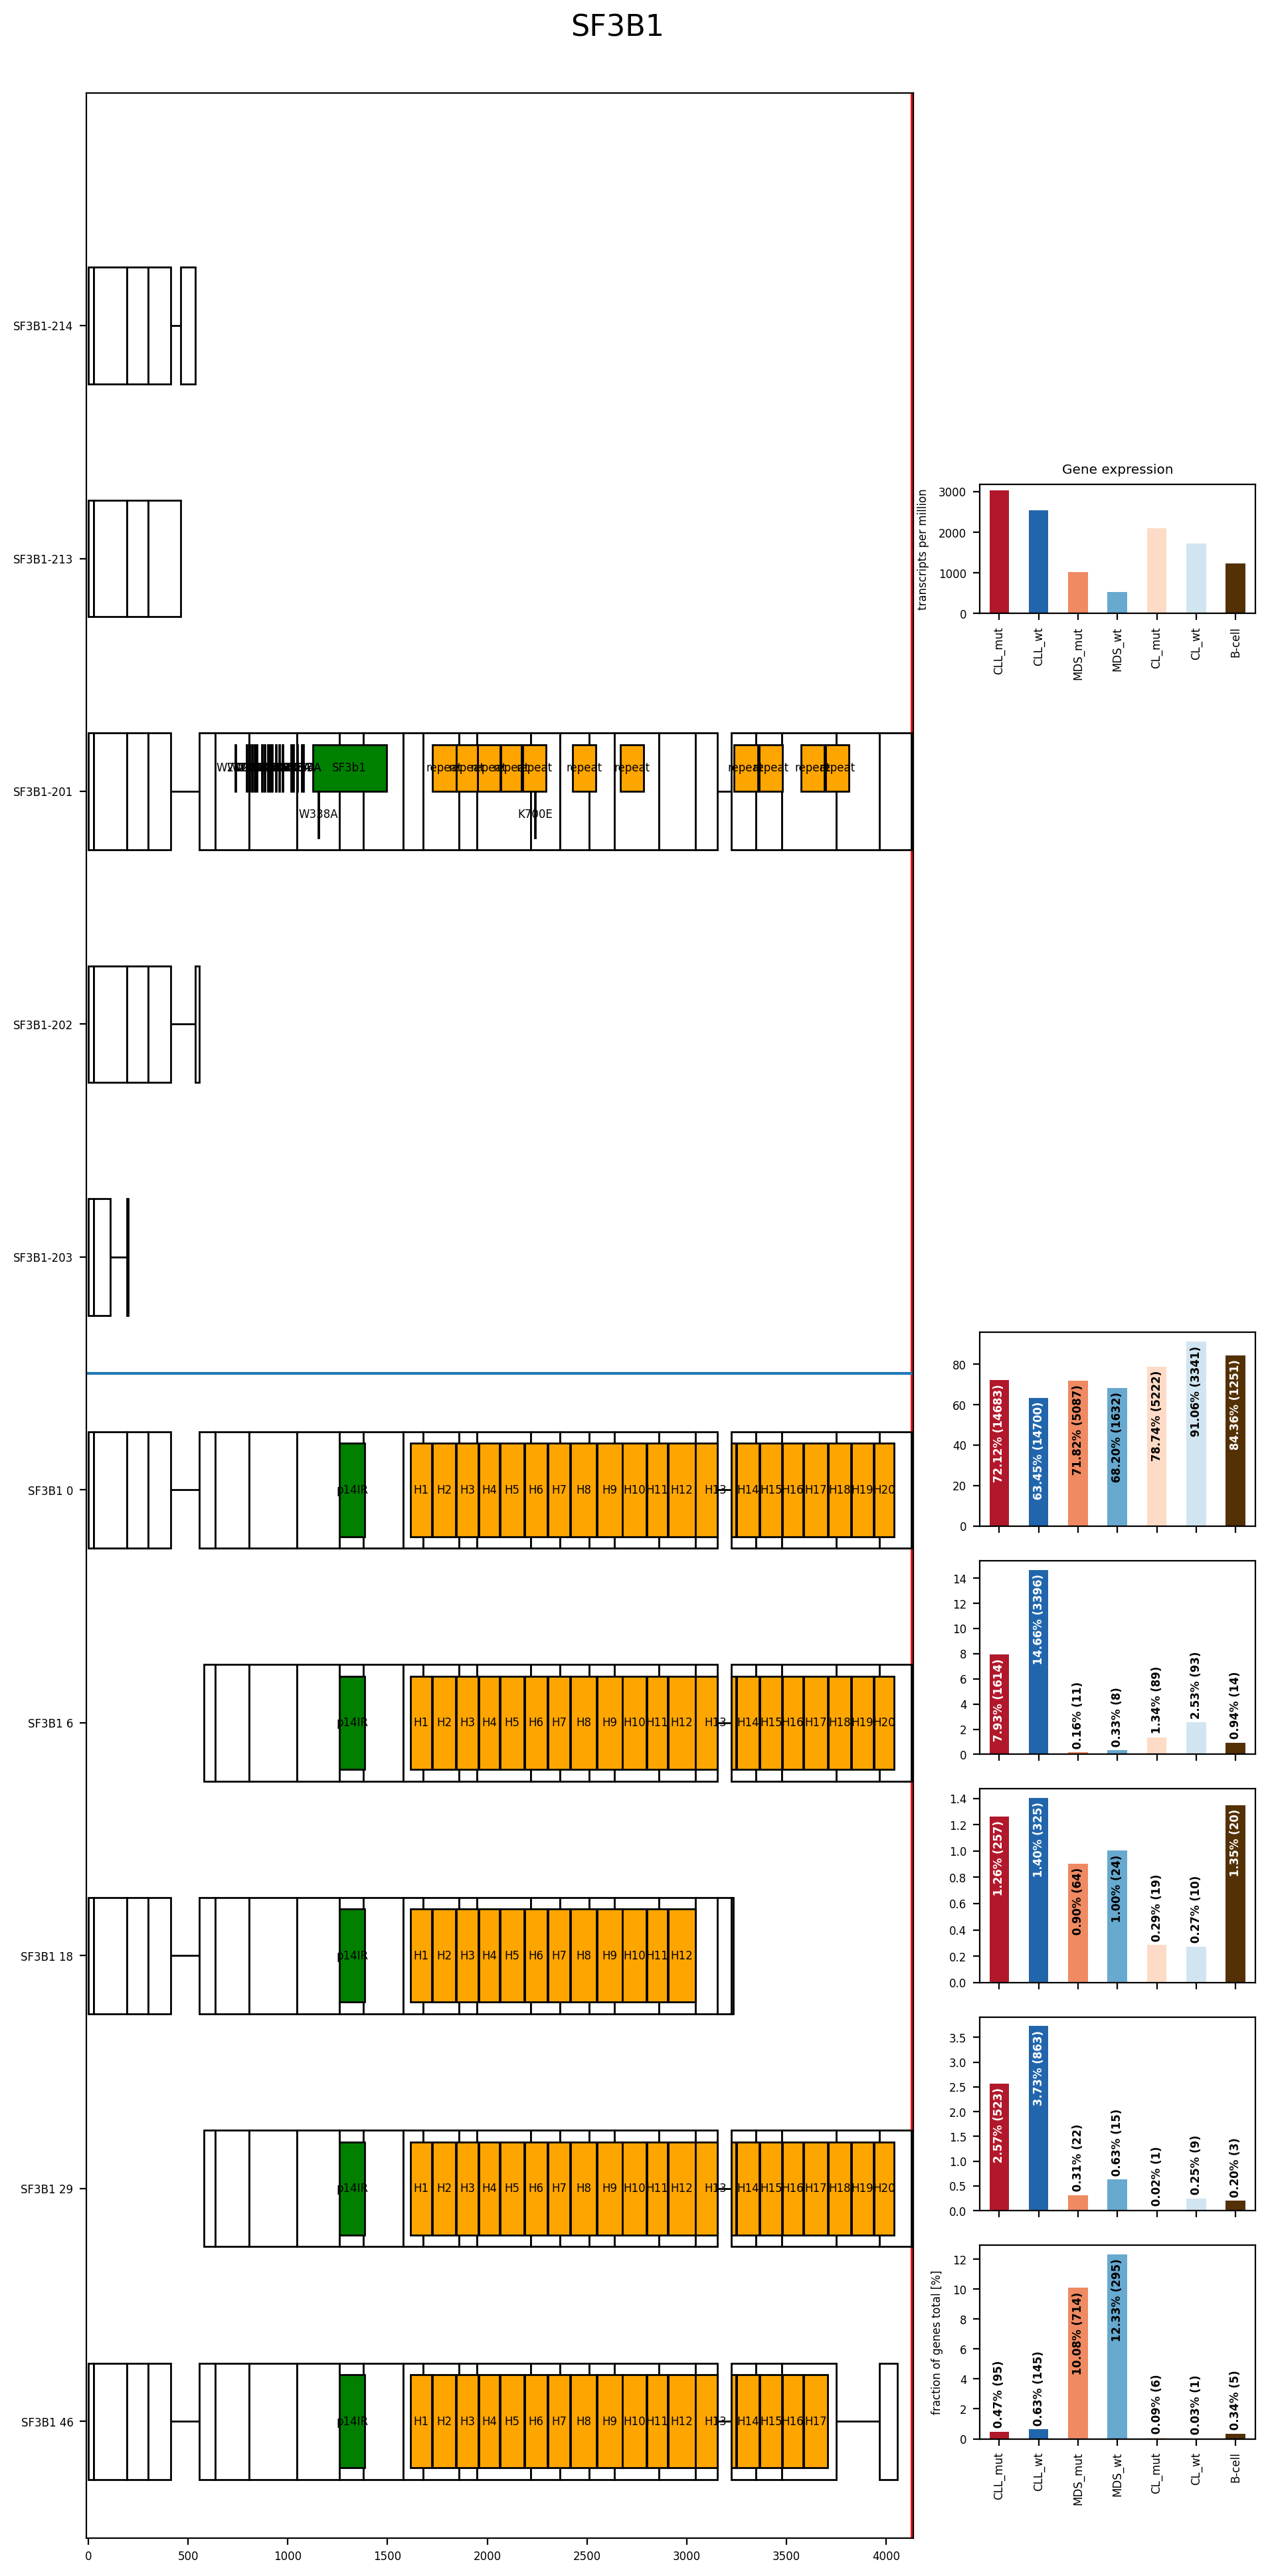

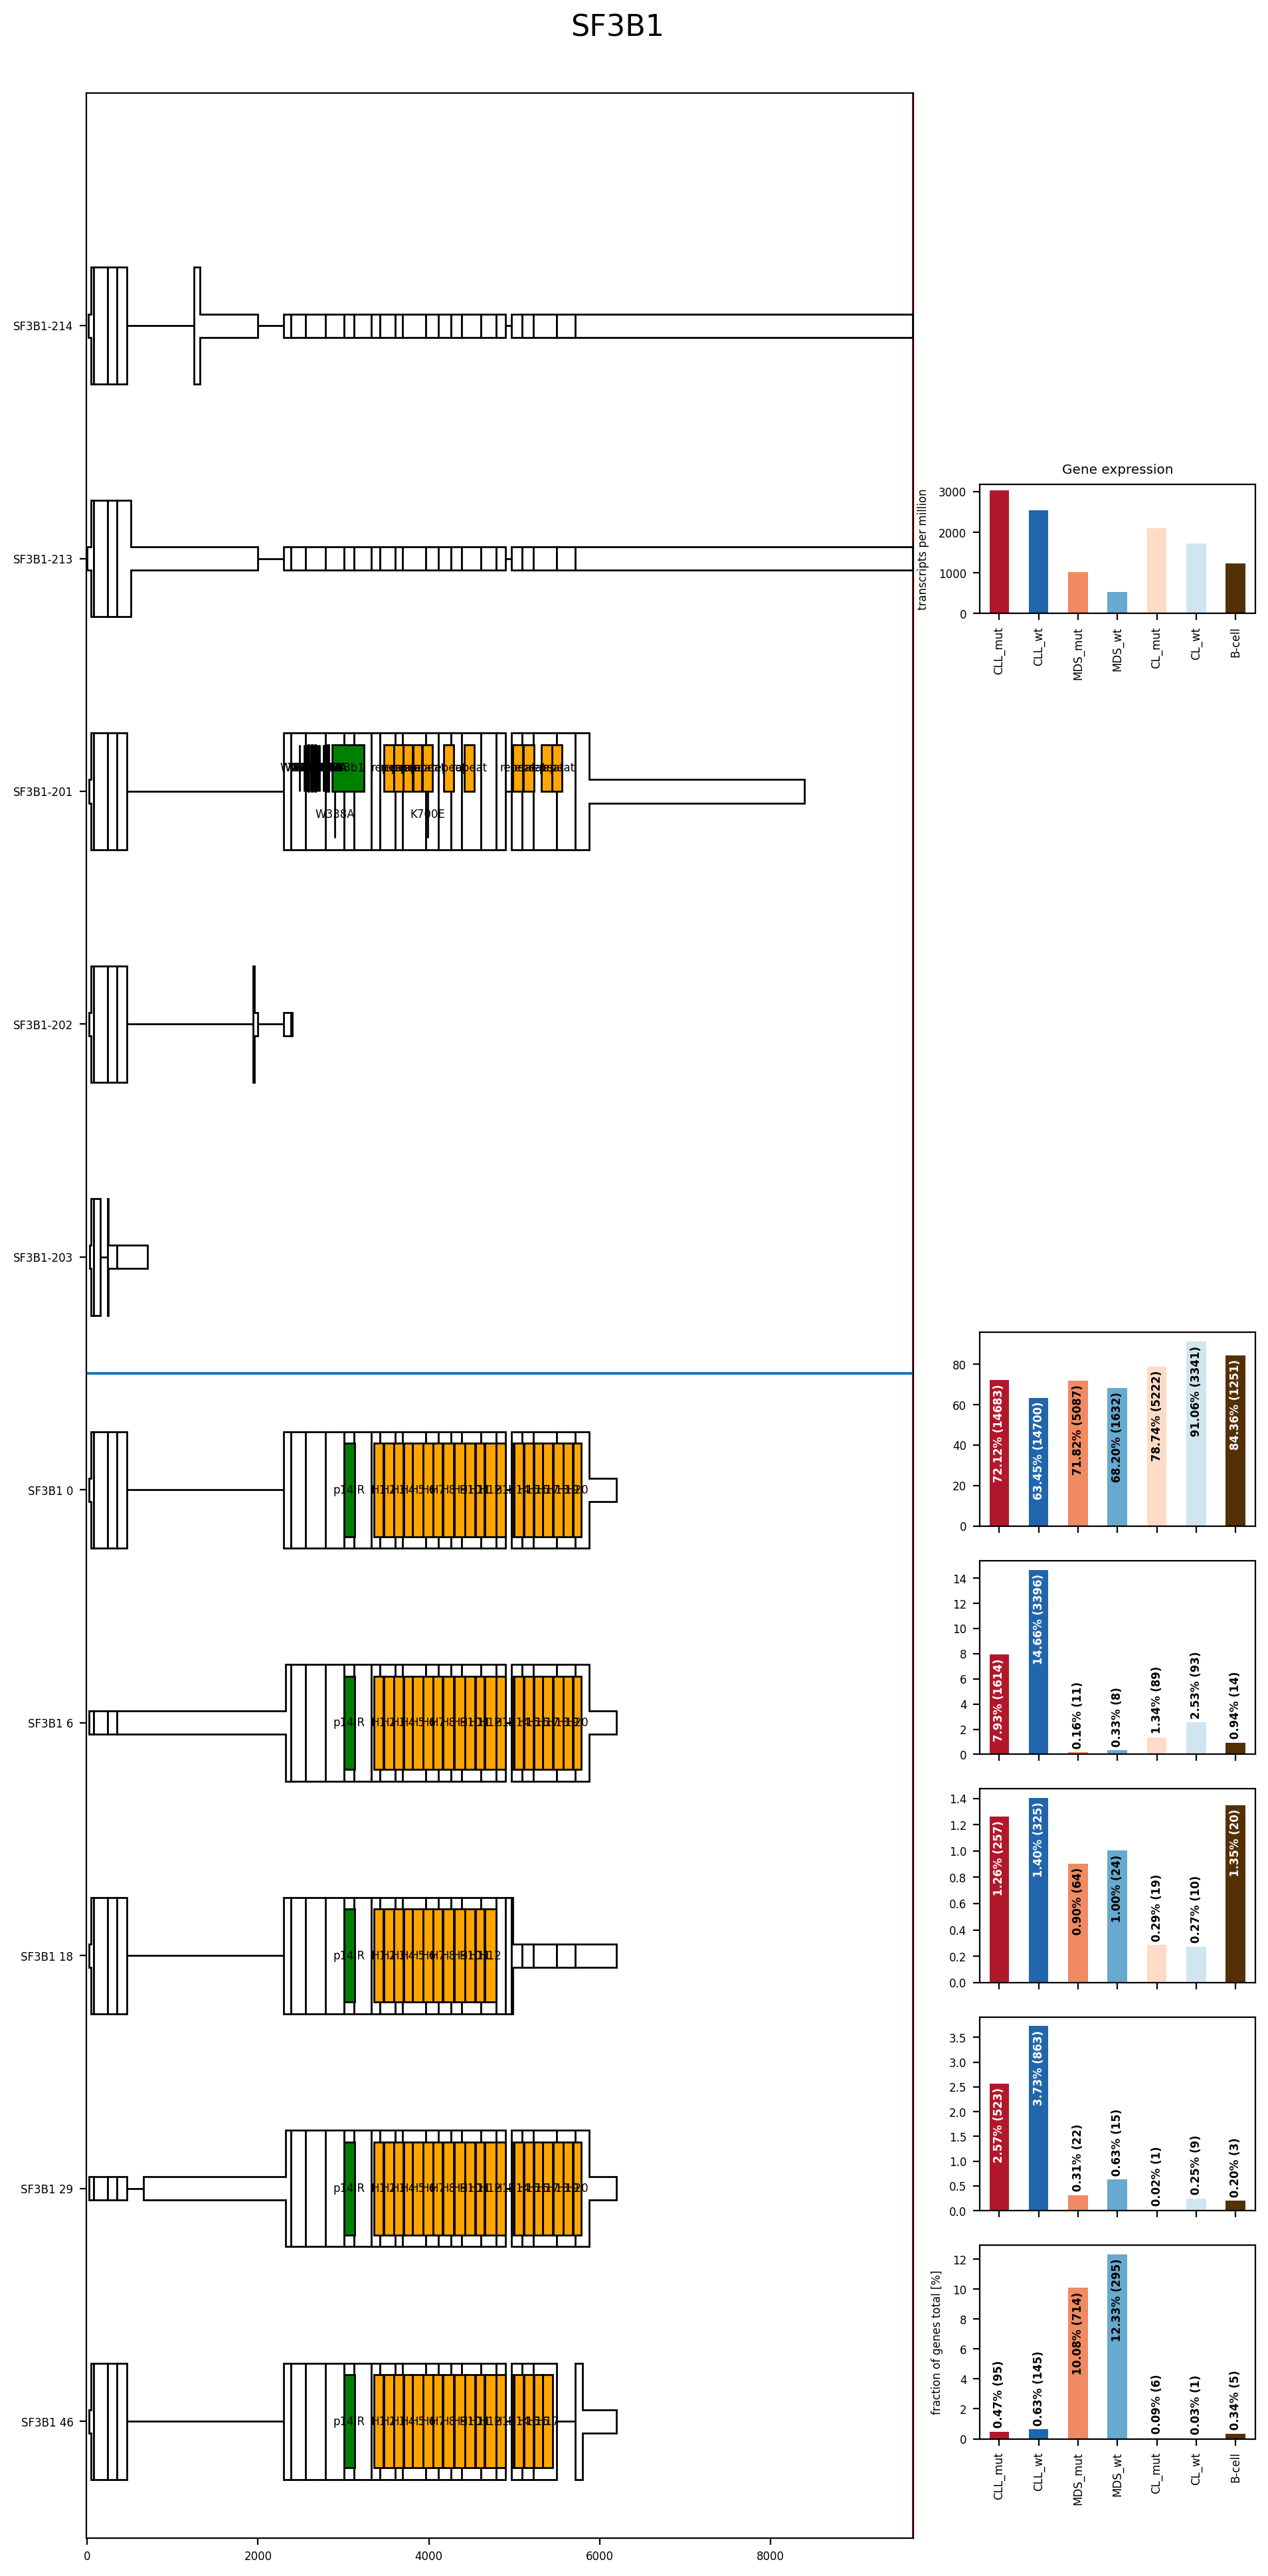

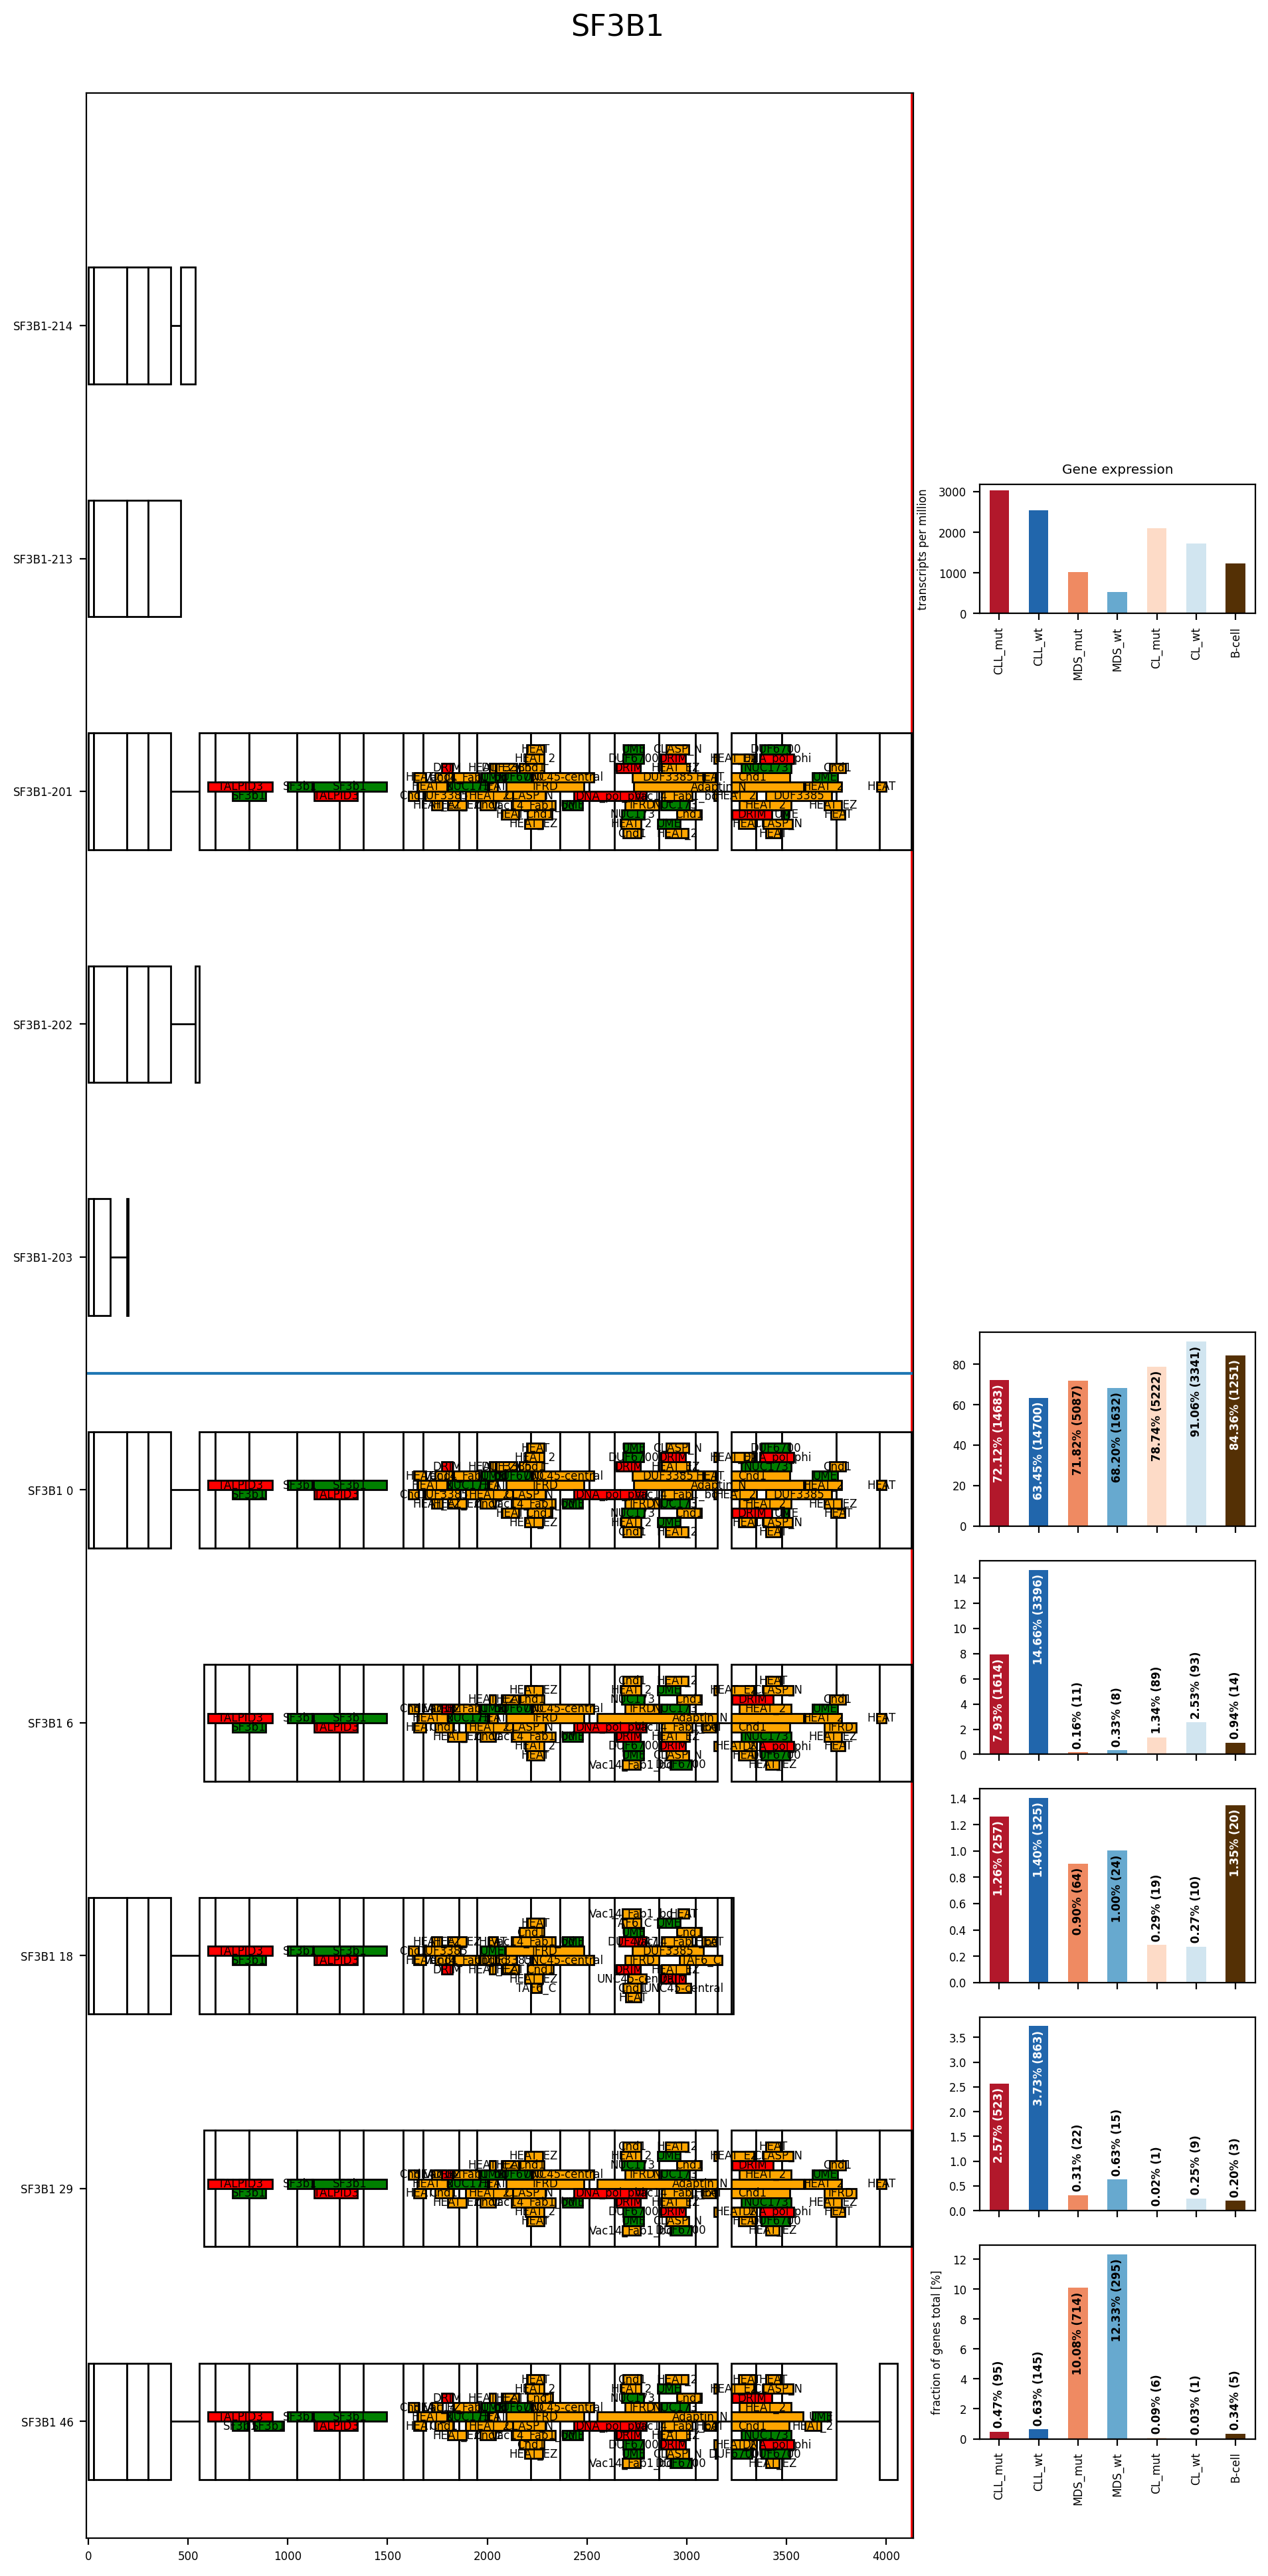

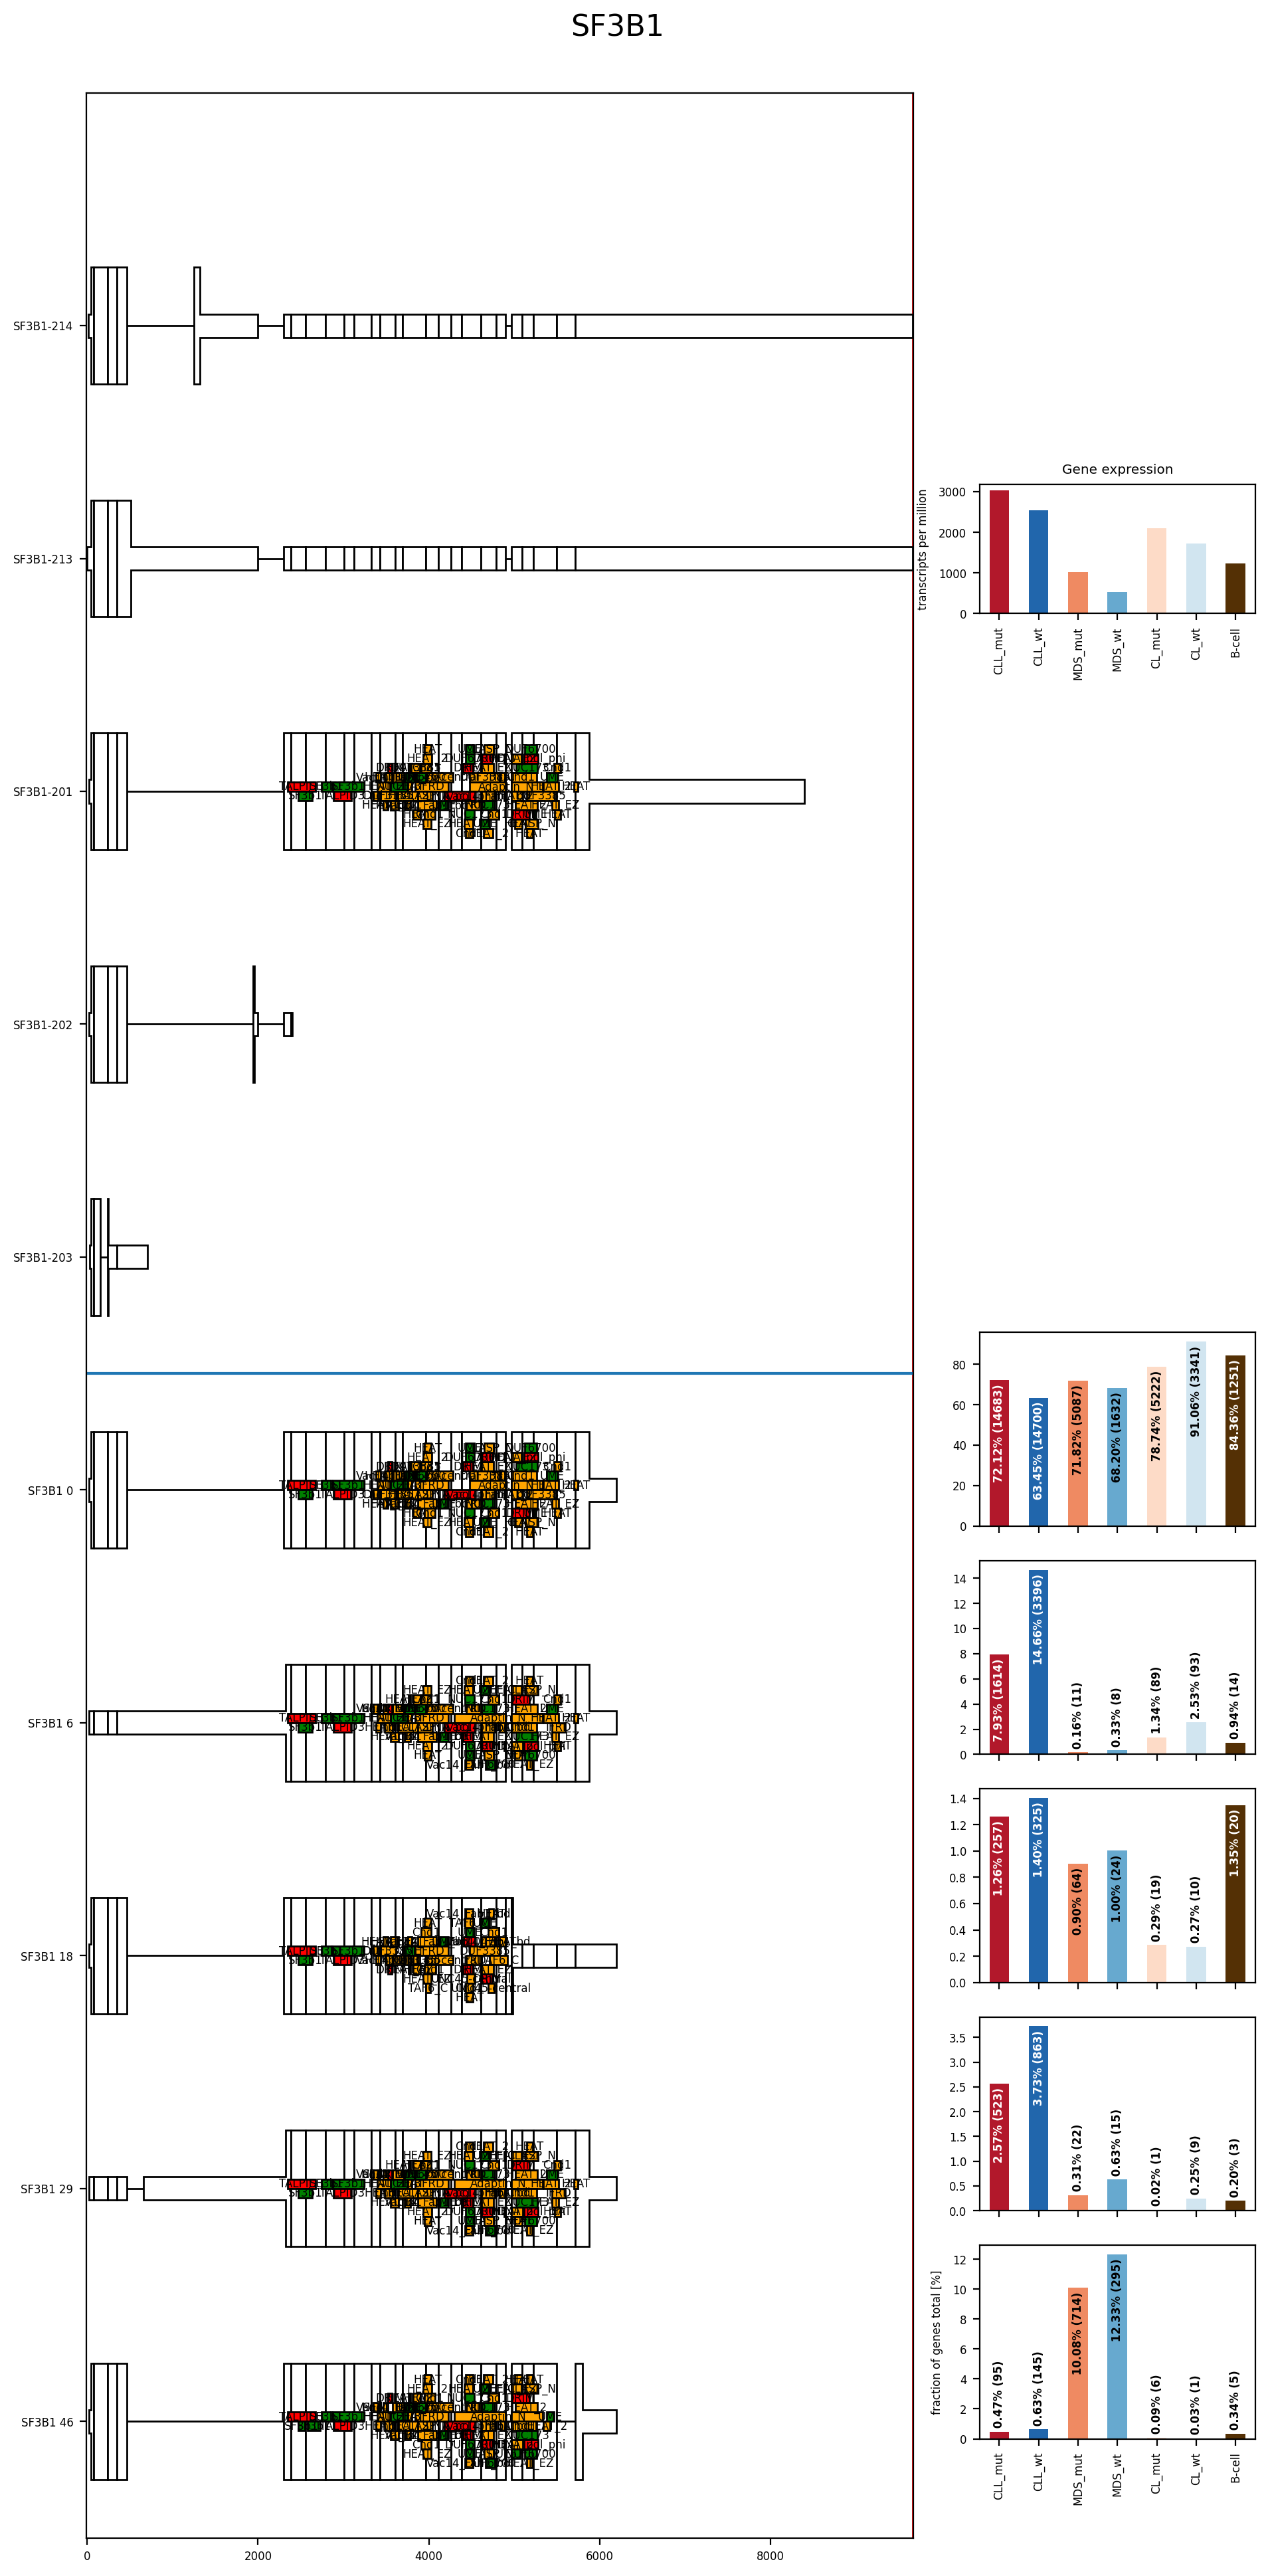

In [16]:
import seaborn as sns
from scipy.stats import beta, nbinom

#isoseq.add_filter( 'SUBSTANTIAL', 'g.coverage.sum() * .05 < g.coverage[:,trid].sum()',context='transcript') # at least 1 % (default 5%)

# check selected transcripts: several diff events per gene - correct trA/trB?
# check NONO IR and SLC7A7 PAS

dom_cols={'domains':'green', 'repeat':'orange' ,'extracellular':'yellow', 'transmembrane':'pink', 'cytoplasmic':'red', "mutations":"grey"}
plt.rcParams["font.size"]=6

sidx = {sa: i for i, sa in enumerate(isoseq.samples)}  # idx
group_idx = {gn: [sidx[sa] for sa in gr] for gn, gr in groups.items()}
sample_colors = {sa: sample_colors.get(sa, group_colors[gn]) for gn in groups for sa in groups[gn]}
sa_groups={sa:gr for gr,salist in groups.items() for sa in salist}

cmp_groups={k:v for k,v in gr.items() if 'all' in k}
x = [i / 100 for i in range(101)] 
pt_size=20
lw=1
ls='solid'
total_reads=pd.Series({gn:isoseq.sample_table.set_index('name')['nonchimeric_reads'][trids].sum() for gn, trids in groups.items()})
from isotools._gene_plots import DOMAIN_COLS
n_plot=0
#sig=res['all'].query('padj<.1')
for goi in ['SF3B1']:
#for idx, row in sig_union.iterrows():

    g=isoseq[goi]
    print(f'{idx}: {g}')
    substantial=g.filter_transcripts(query='SUBSTANTIAL')   
    
    orf_tr={}
    for i, tr in enumerate(g.ref_transcripts):
        if 'CDS' in tr:
            if tr['CDS'] not in orf_tr:
                orf_tr[tr['CDS']]=i
    ntr=len(substantial)+max(2,len(orf_tr))
    
    
    plt.rcParams["figure.figsize"] = (7,5)
    #fig, ax=plt.subplots()
    #ax=g.gene_track(select_transcripts=trA+trB, reference=False, ax=ax)
    #fig.savefig(f"{plot_path}/{project}_{date}_{idx}_{g.name}_gene_track.pdf")
    #plt.close(fig)
    
    # barplots
    count_table={'total':[g.coverage[grp,:].sum()for grp in group_idx.values()] }
    for trid in substantial:
        count_table[trid]=[g.coverage[grp,trid].sum(0) for grp in group_idx.values()]
    count_table=pd.DataFrame.from_dict(count_table, orient='index', columns=group_idx)
    count_table=count_table[['CLL_mut','CLL_wt','MDS_mut','MDS_wt' ,'CL_mut','CL_wt' ,'B-cell']]
    total = count_table.loc['total']
    count_table = count_table.drop('total')
    fractions = (count_table / total * 100)
    #swarmplot
    min_cov=10
    
    
    plt.rcParams["figure.figsize"] = (10,ntr*2)
    for source in ['annotation','hmmer' ]: 
        for utr in False,True:            
            fig = plt.figure()
            fig.suptitle(f'{g.name}', fontsize=16)

            gs = fig.add_gridspec(nrows=ntr+2, ncols=2, left=0.1, right=0.98,top=.95,bottom=.03, hspace=0.2, wspace=0.12, width_ratios=[3,1], height_ratios=[3,2,2]+[3]*(ntr-2)+[1])
            ax = fig.add_subplot(gs[:, 0])
            domain_cols=dom_cols if source=='annotation' else DOMAIN_COLS
            ax,gmap=g.plot_domains(source=source,categories=domain_cols, ref_trids=orf_tr.values(), trids=substantial, include_utr=utr, max_overlap=10,highlight=roi, domain_cols=domain_cols, ax=ax)
            ax.set_ylim(-len(orf_tr)-len(substantial)+.5, max(1, 3-len(orf_tr))) # add 2 blank lines when there is no reference
            ax.axhline(-len(orf_tr)+.5,0,1)
            
            #### bee plot
            
            ax_gene=fig.add_subplot(gs[2, 1])
            ax_gene.set_ylabel('transcripts per million', labelpad=5)
            tpm=(total/total_reads*1e6)[total.index]
            tpm.plot.bar(ax=ax_gene, color=[group_colors[gn] for gn in tpm.index])
            ax_gene.set_title(label='Gene expression')
            #ax_gene.margins(.2)
            for i,trid in enumerate(substantial):
                where=i+max(len(orf_tr),2)+1
                ax2=fig.add_subplot(gs[where, 1])
                fractions.T.reset_index().plot.bar(x='index', y=trid,legend=False, color=[group_colors[gn] for gn in fractions] , ax=ax2)
                for n, f, p in zip(count_table.T[trid], fractions.T[trid], ax2.patches):
                    small = f < max(fractions.T[trid]) / 2
                    # contrast=tuple(1-cv for cv in p.get_facecolor()[:3])
                    contrast = 'white' if np.mean(p.get_facecolor()[:3]) < .5 else 'black'
                    ax2.annotate(f' {f/100:.2%} ({n}) ', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center',
                                va='bottom' if small else 'top', rotation=90, color='black' if small else contrast, fontweight='bold')
                ax2.set_xlabel('')
                ax2.tick_params('x', labelbottom=False)
                #ax.margins(0.2)
            ax2.set_ylabel('fraction of genes total [%]', labelpad=5)
            ax2.tick_params('x', labelbottom=True)
            n_plot+=1
            fig.savefig(f"{plot_path}/{project}_{date}_domains_{idx:03}_{g.name}_{row.splice_type}_{source}{'_utr' if utr else ''}.pdf")
        
            #plt.close(fig)
        